In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import utils
import skutils

# Use ggplot style
plt.style.use('ggplot')

%matplotlib inline

In [2]:
train_data = pd.read_csv('../input/train.csv')

In [3]:
skutils.pretty_stats(train_data)

property,values
Number of features,132
Number of categorical features,116
Number of numerical features,16
Number of Samples,188318


feature,Unique,NaN,min,min count,mean,max,max count
id,188318,0,1.0,1,294135.982561,587633.0,1
cont1,647,0,1.6e-05,225,0.493861364564,0.984975,2
cont2,33,0,0.001149,2,0.507188356179,0.862654,176
cont3,76,0,0.002634,83,0.498918450722,0.944251,4656
cont4,112,0,0.176921,1119,0.491812302589,0.954297,1
cont5,141,0,0.281143,51926,0.487427728783,0.983674,2
cont6,2573,0,0.012683,216,0.490944533735,0.997162,6
cont7,5632,0,0.069503,303,0.484970205068,1.0,30
cont8,201,0,0.23688,1020,0.48643731587,0.9802,264
cont9,347,0,8e-05,174,0.485506319895,0.9954,1


feature,Num Categories,Categories,NaN
cat1,2,"['A', 'B']",0
cat2,2,"['A', 'B']",0
cat3,2,"['A', 'B']",0
cat4,2,"['A', 'B']",0
cat5,2,"['A', 'B']",0
cat6,2,"['A', 'B']",0
cat7,2,"['A', 'B']",0
cat8,2,"['A', 'B']",0
cat9,2,"['A', 'B']",0
cat10,2,"['A', 'B']",0


feature,highest value,correlated with,mean
id,0.00553380418024,cont8,0.001943678149
cont1,0.929911705762,cont9,0.397529079768
cont2,0.455860923269,cont3,0.100215976099
cont3,0.455860923269,cont2,0.220548700154
cont4,0.528740297217,cont8,0.191679356673
cont5,0.249343730858,cont7,0.0965070937574
cont6,0.883350506849,cont10,0.448666686983
cont7,0.747107916789,cont11,0.298528544082
cont8,0.528740297217,cont4,0.250987325178
cont9,0.929911705762,cont1,0.412284135654


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


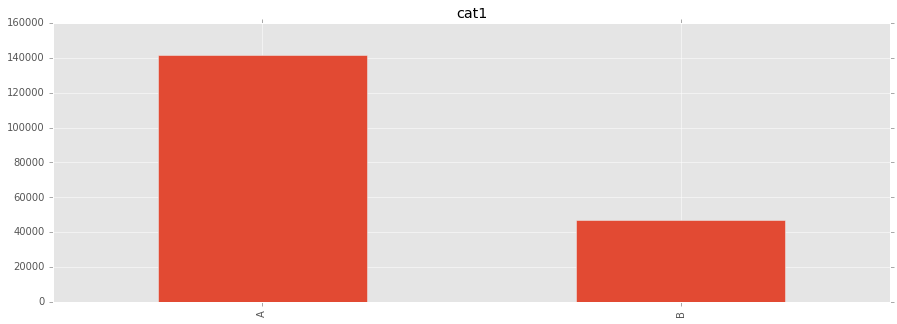

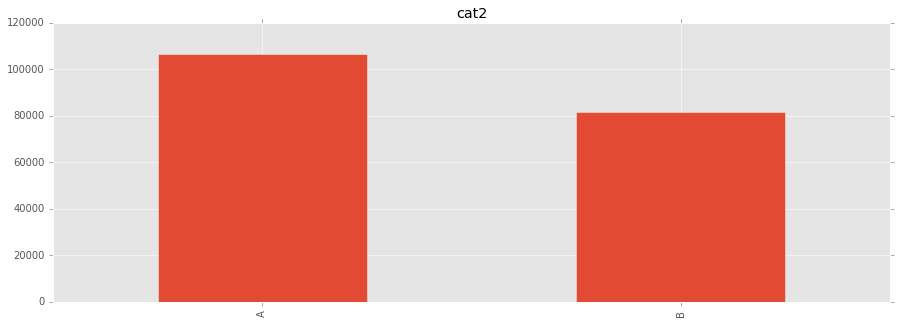

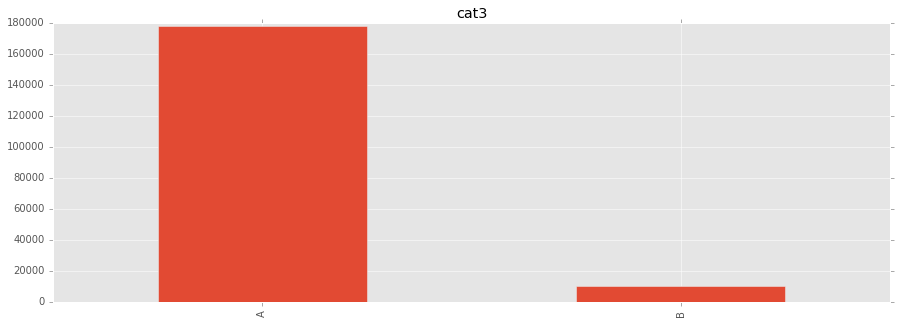

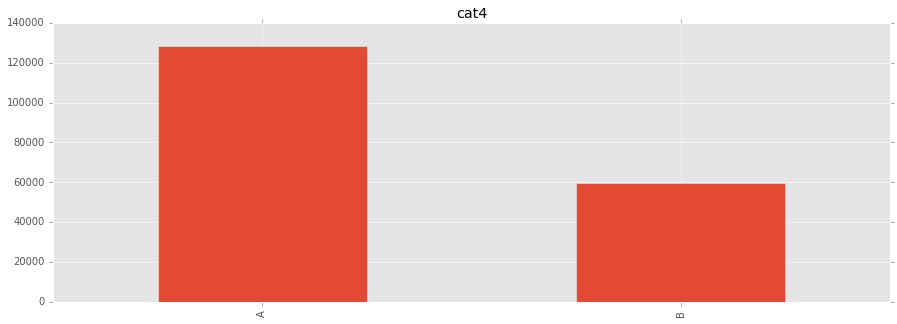

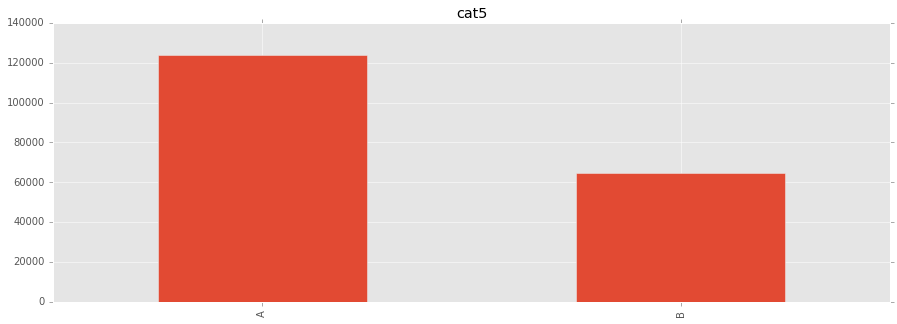

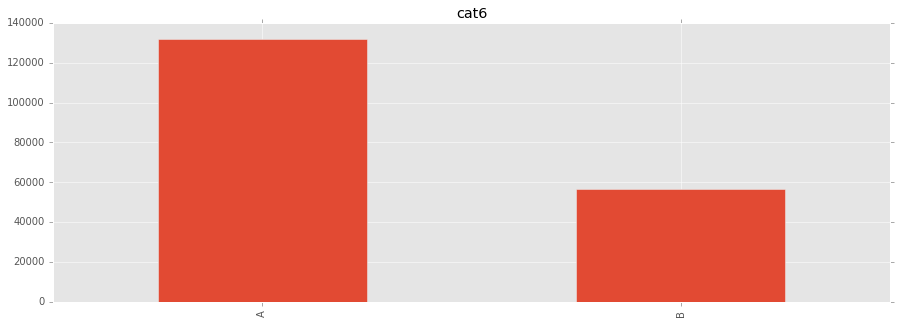

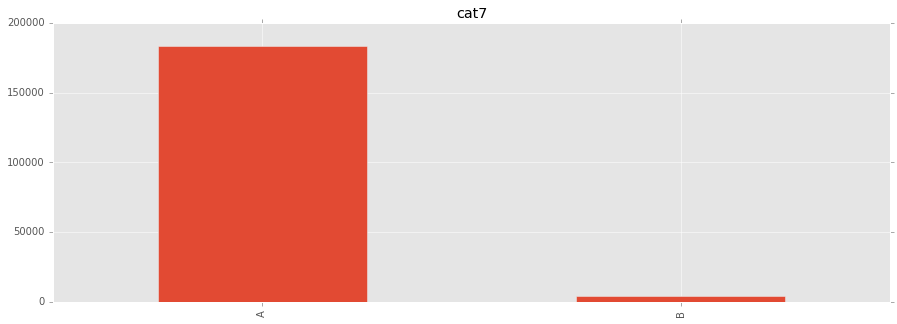

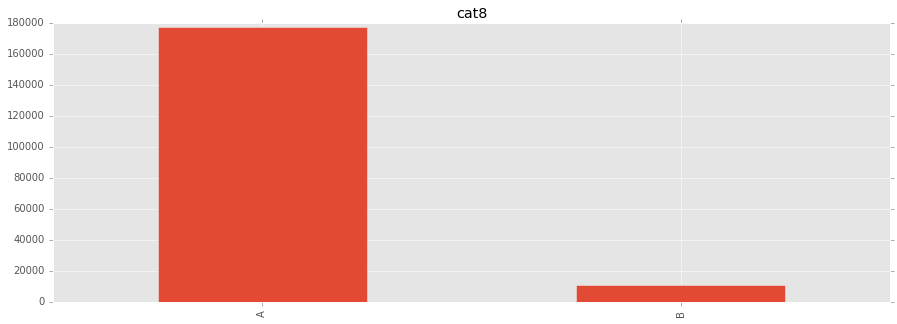

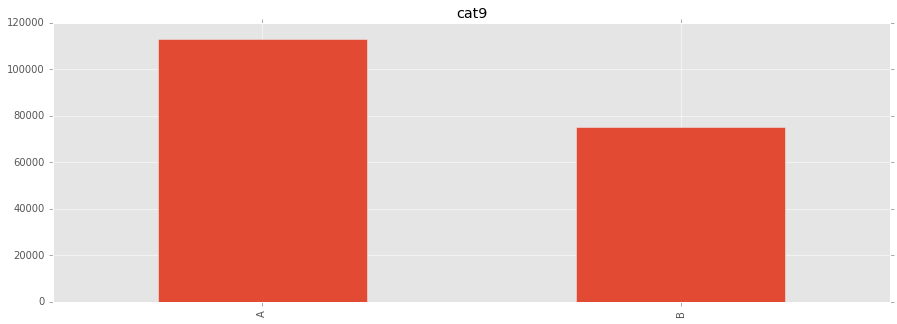

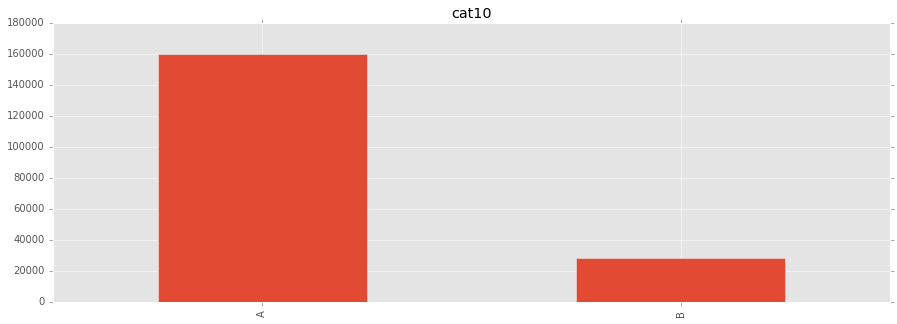

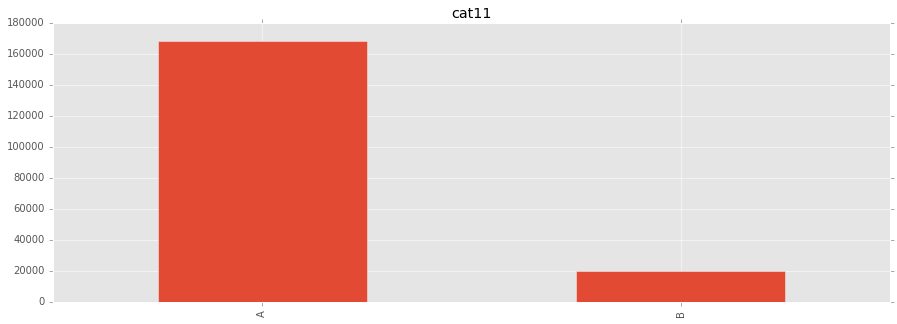

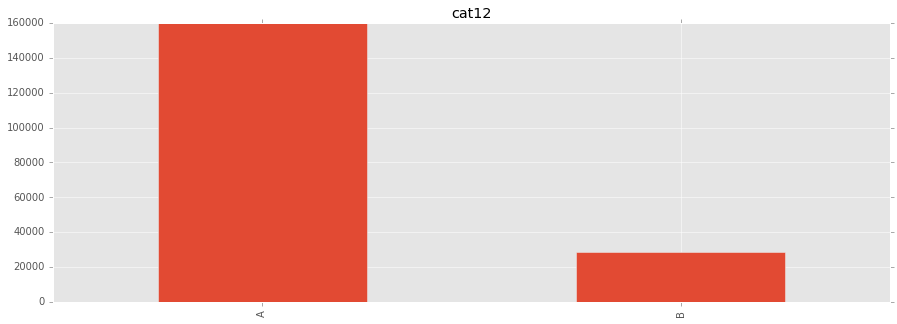

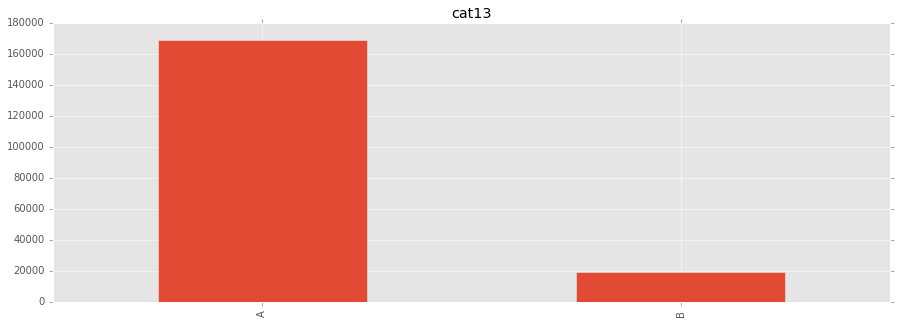

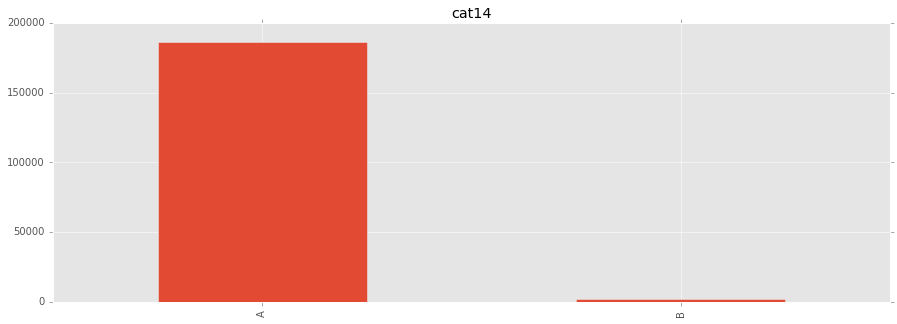

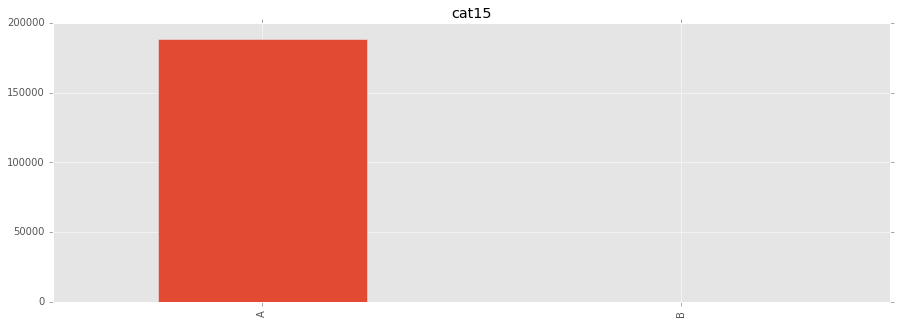

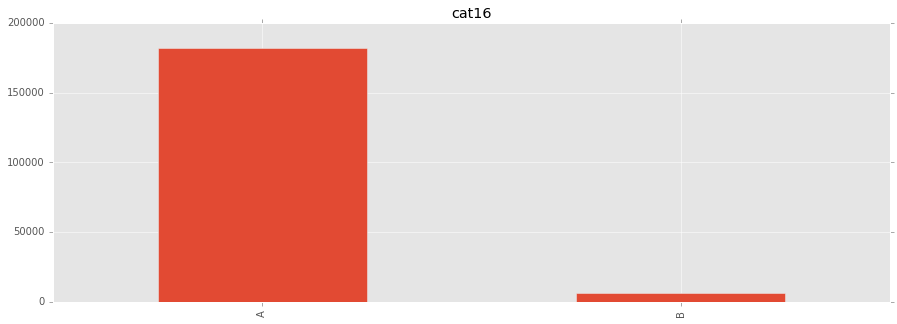

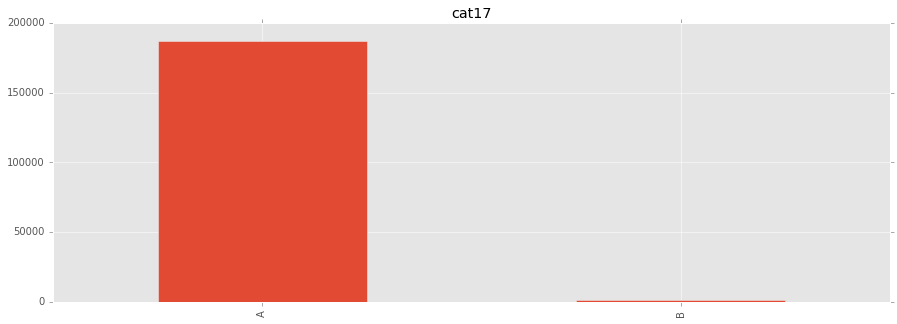

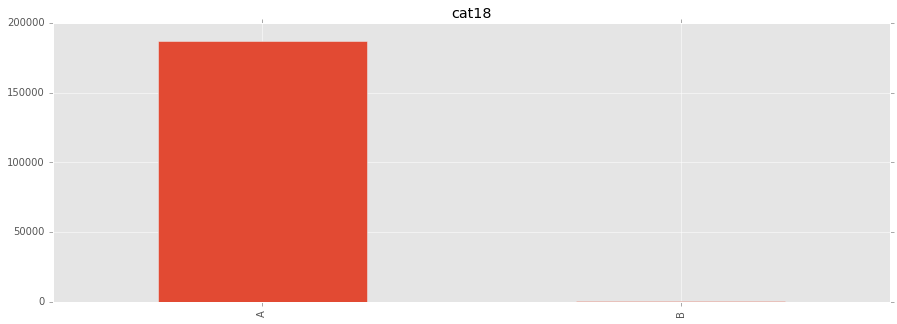

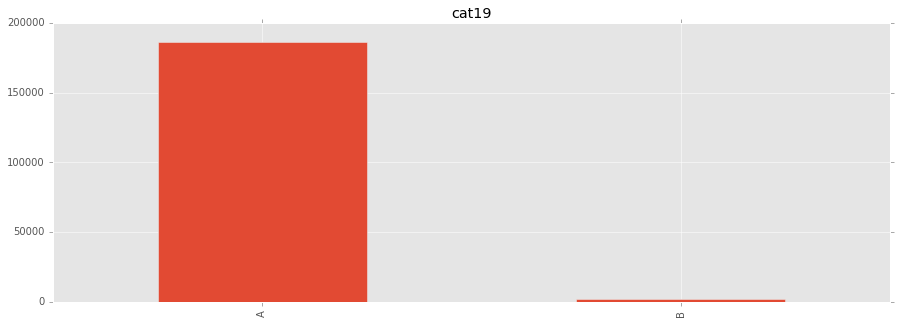

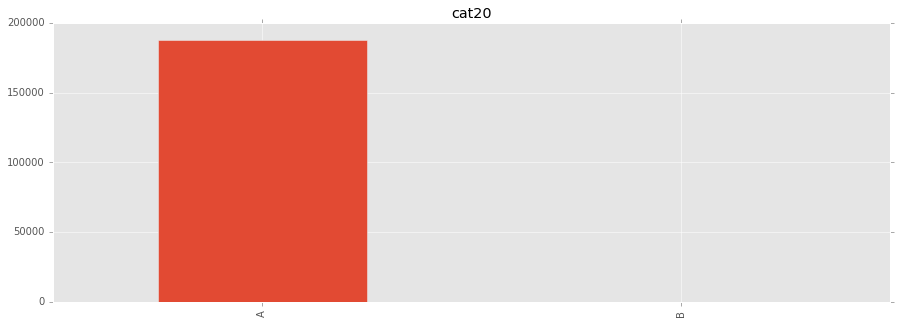

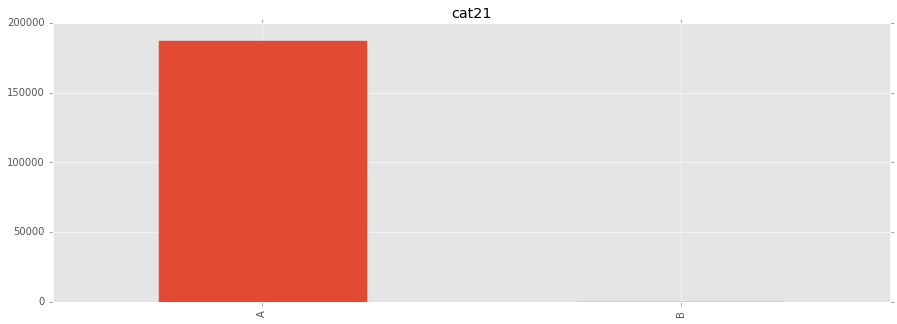

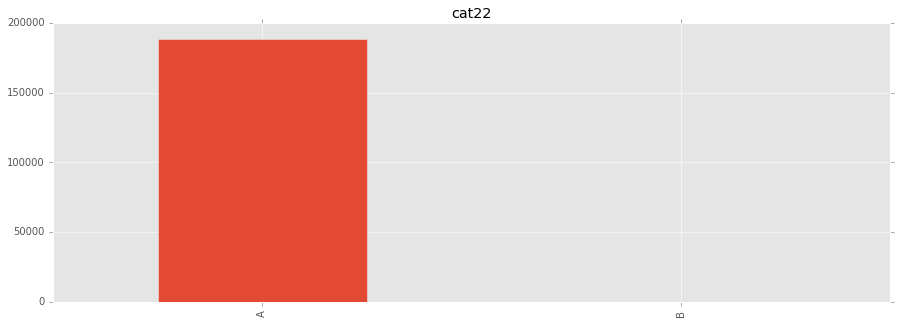

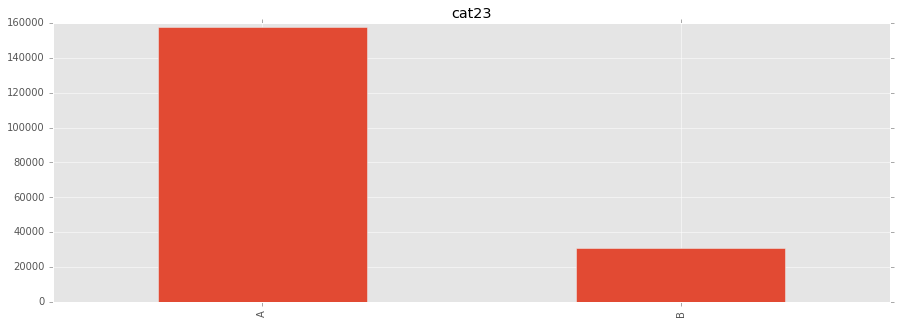

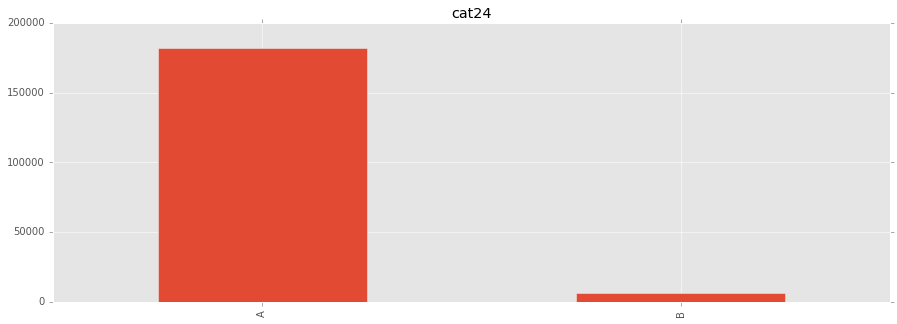

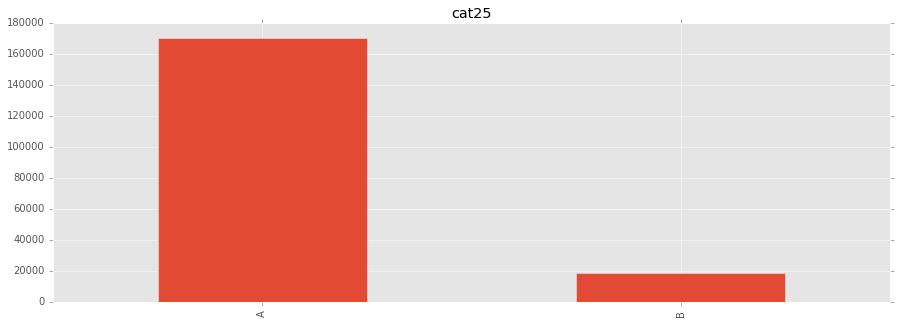

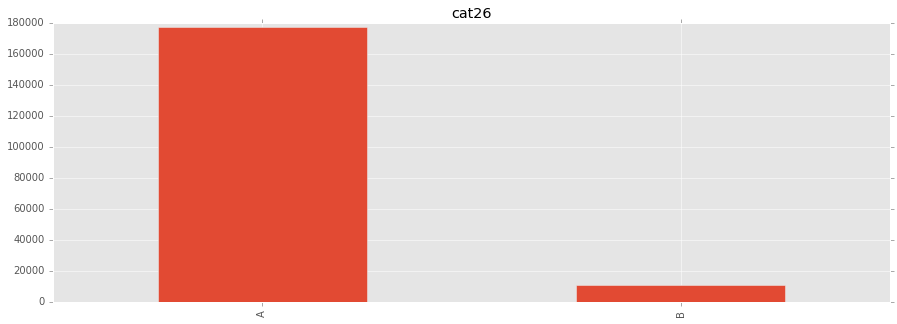

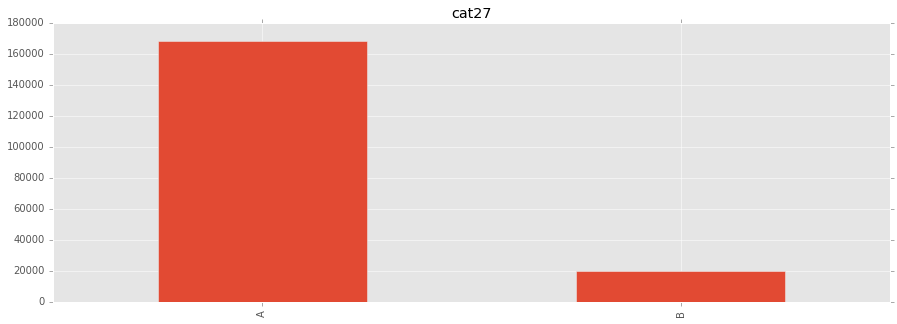

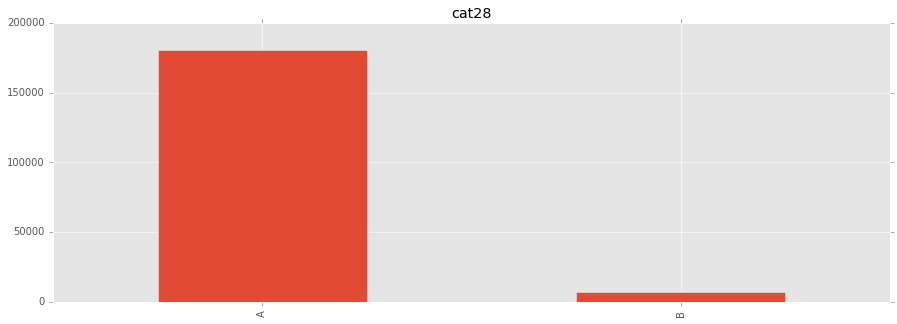

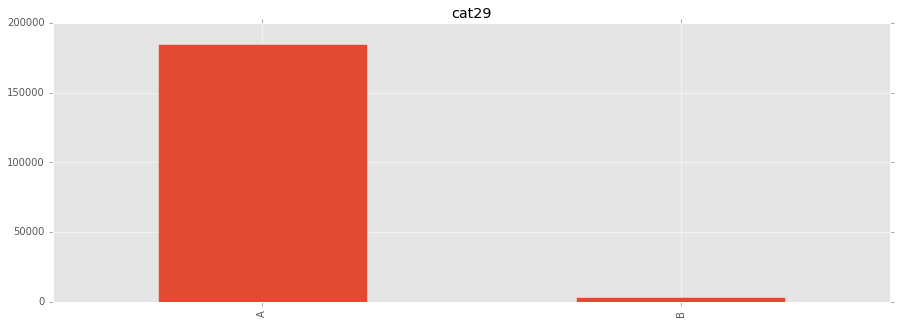

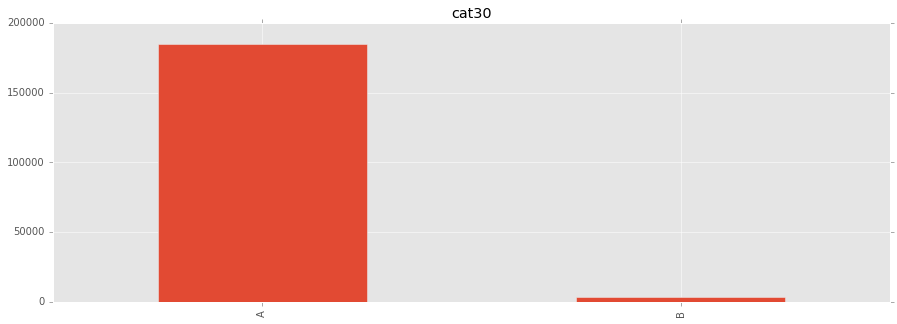

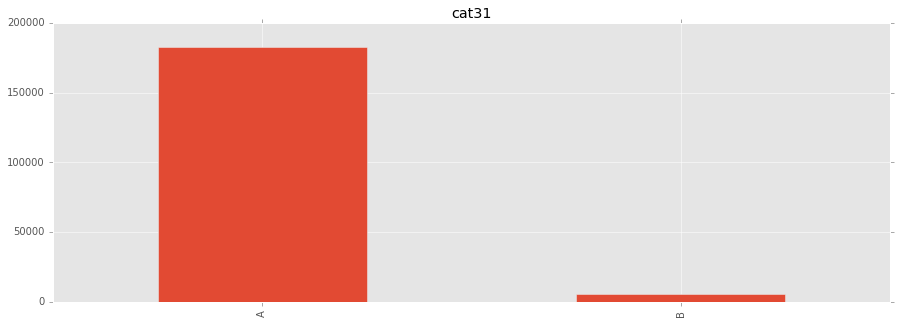

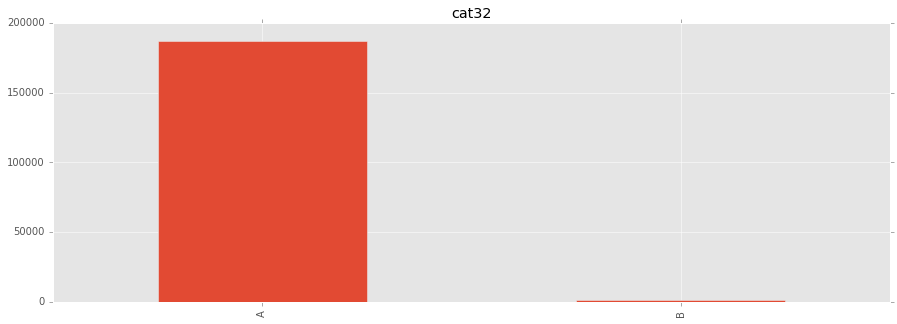

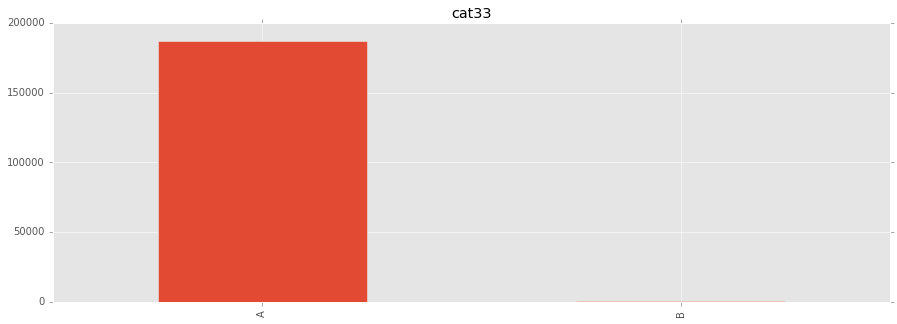

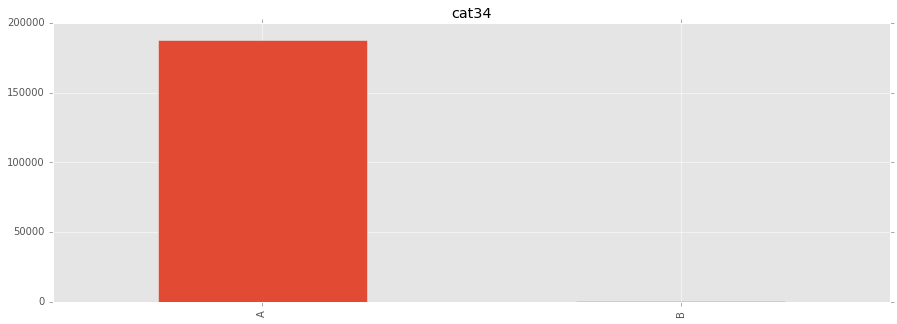

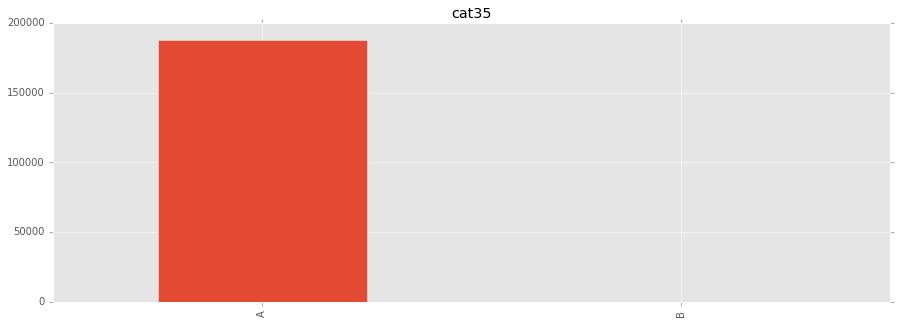

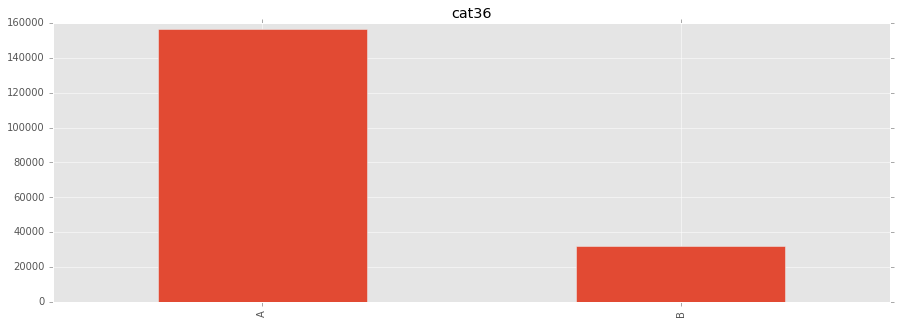

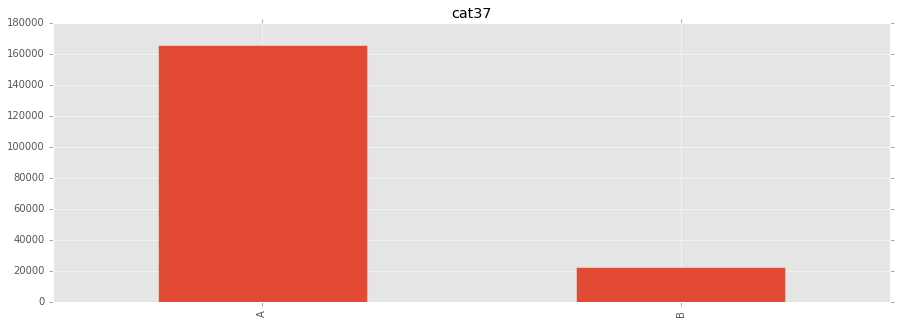

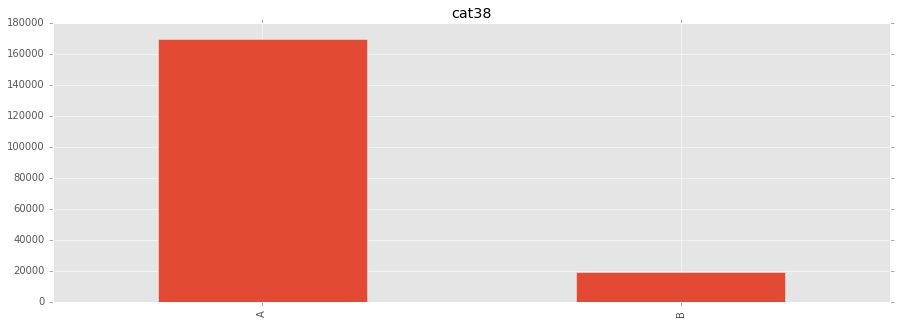

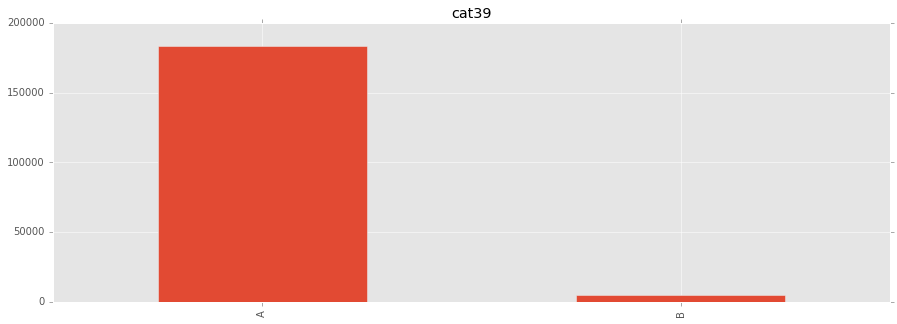

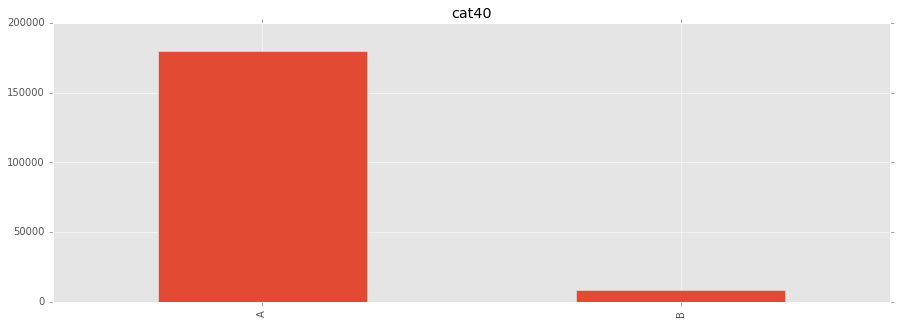

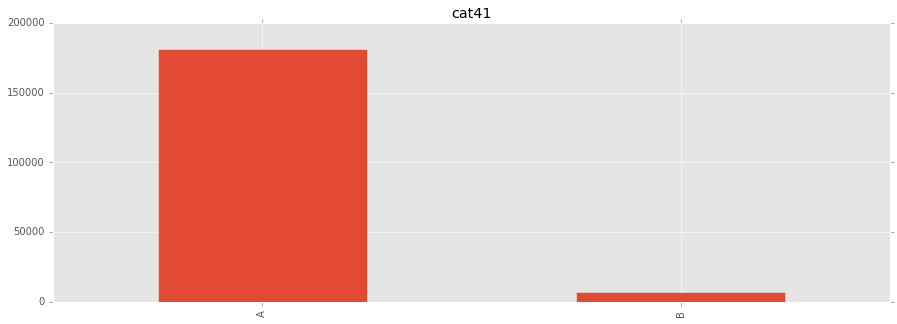

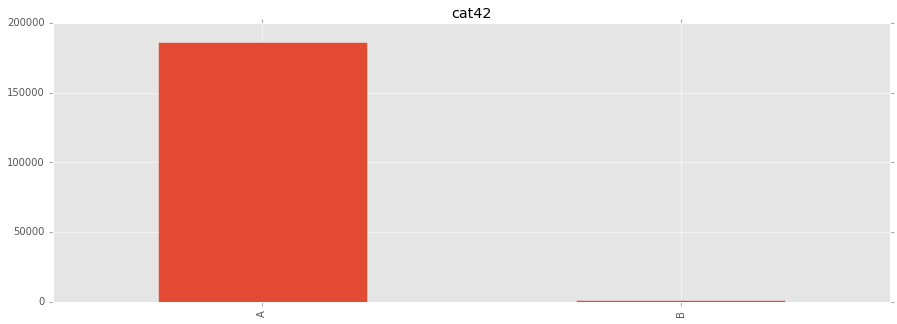

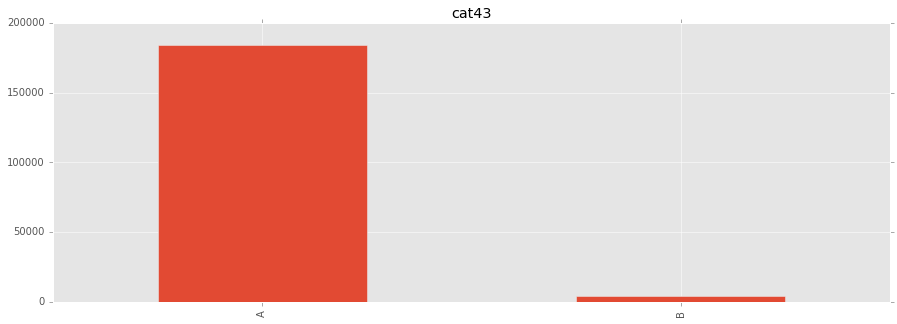

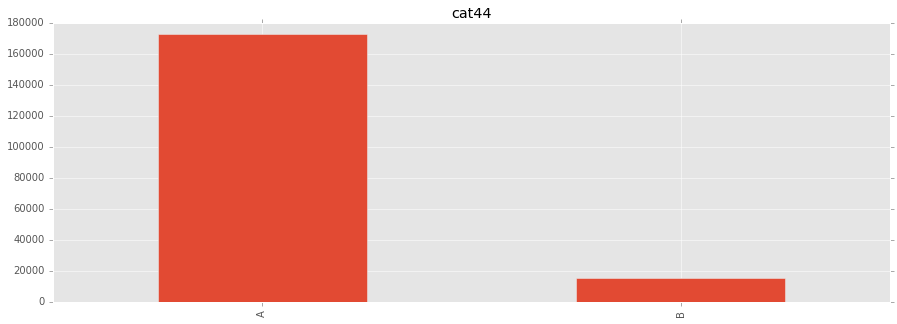

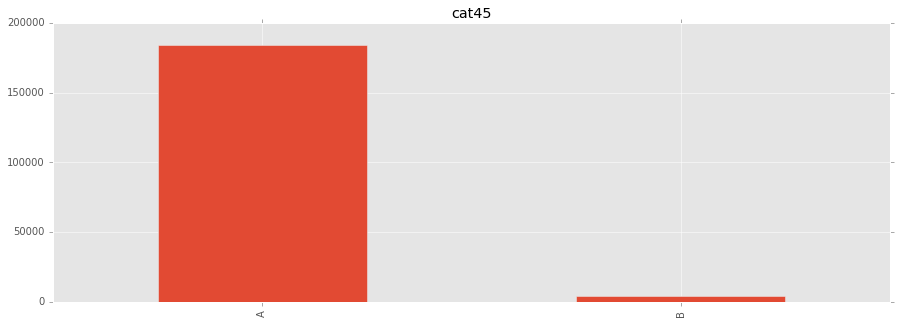

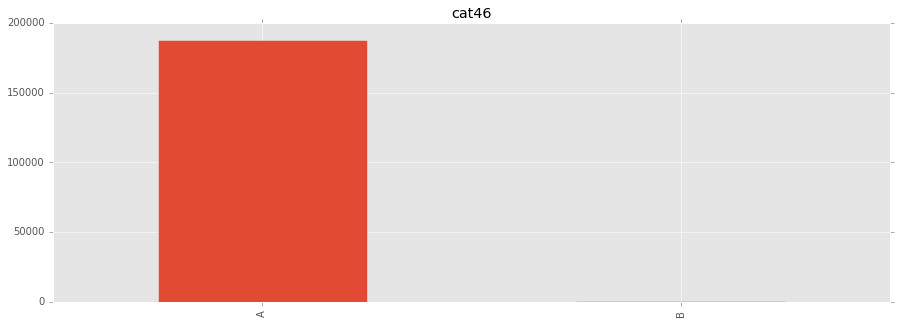

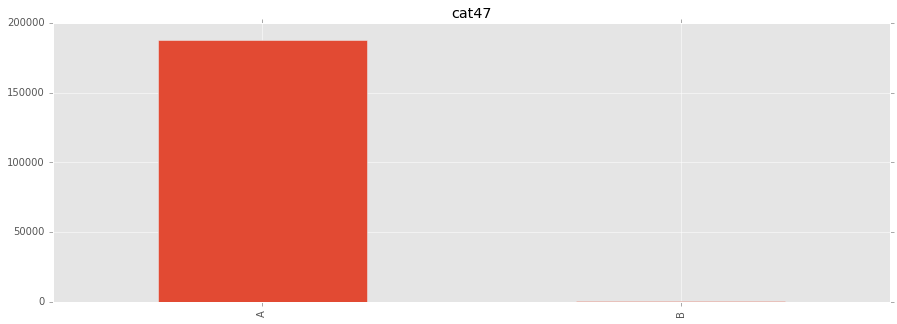

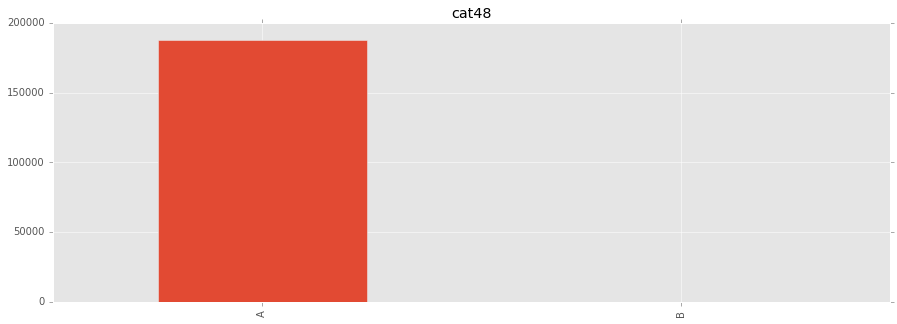

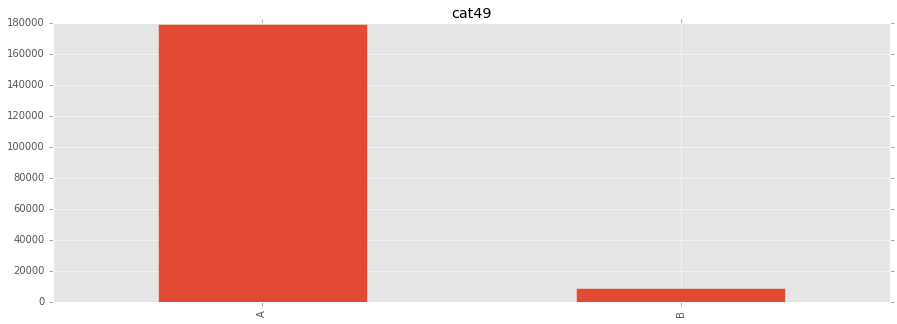

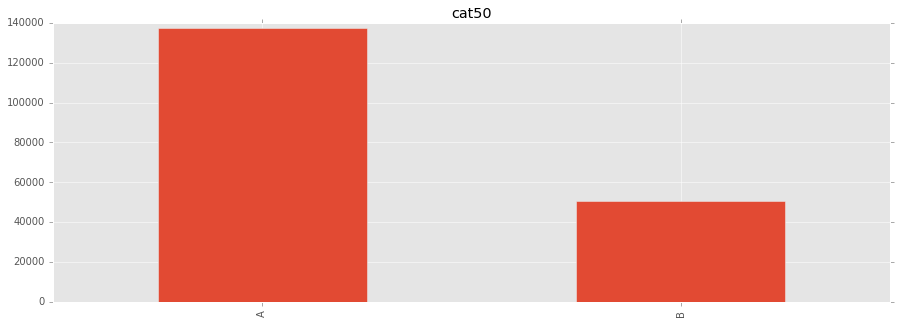

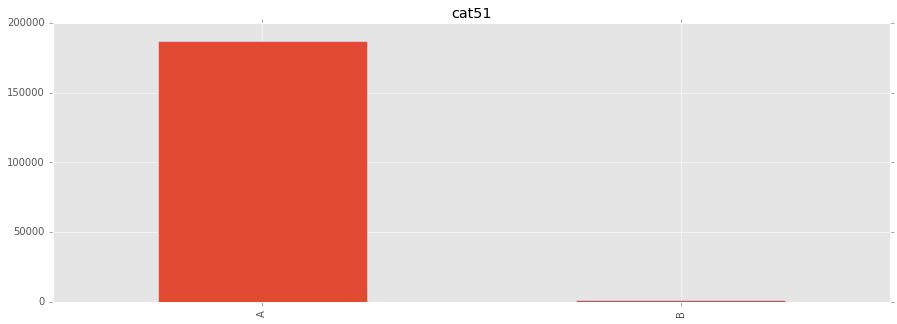

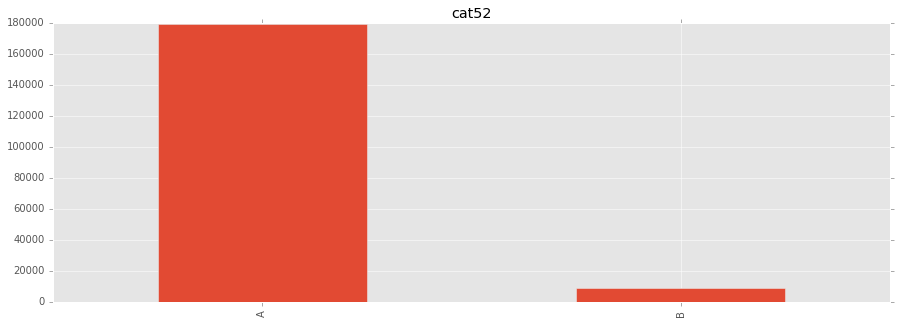

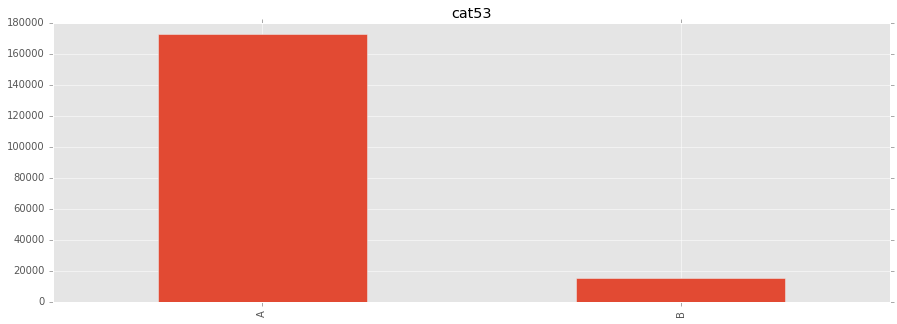

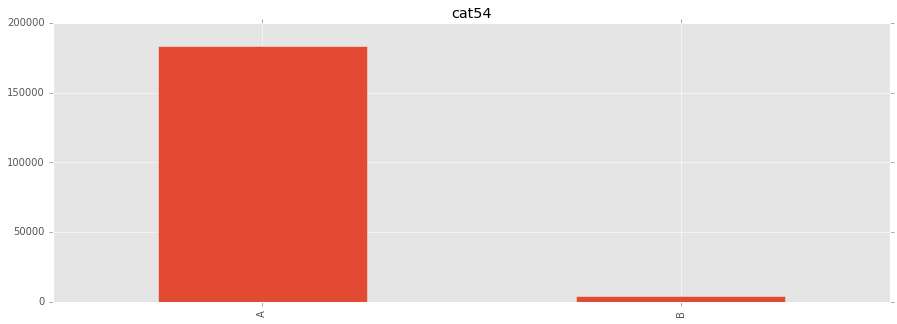

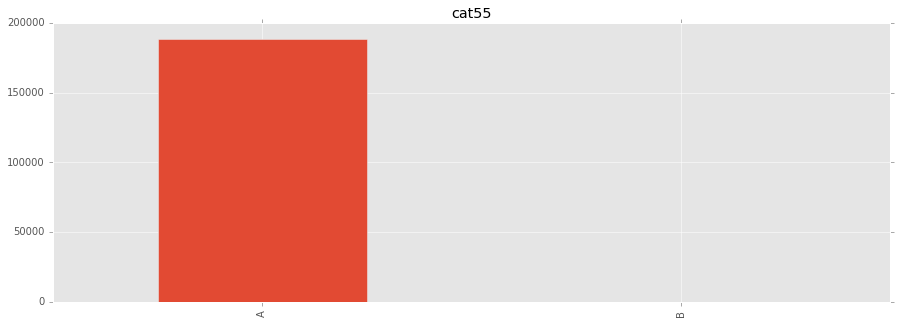

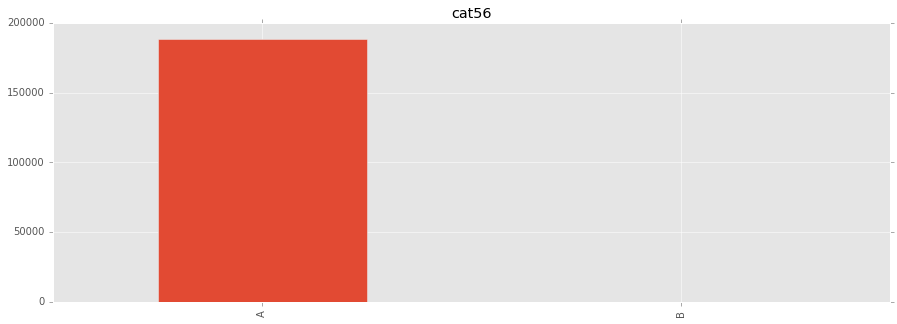

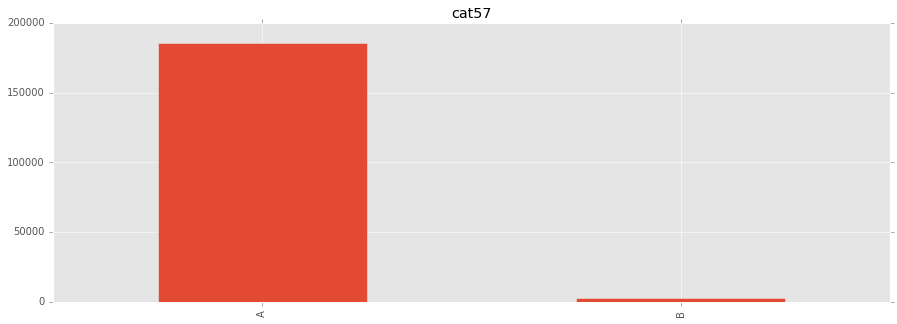

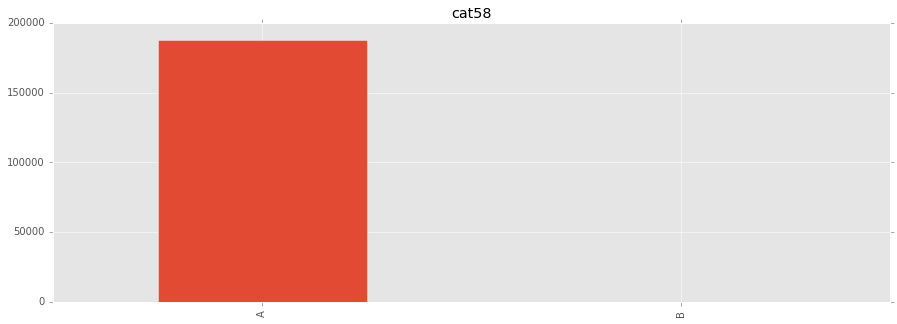

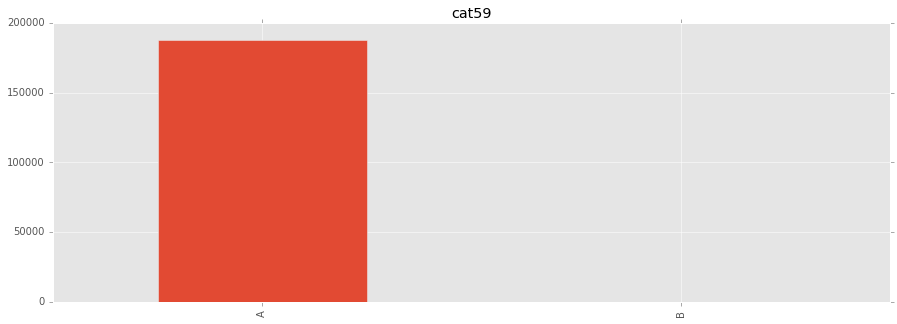

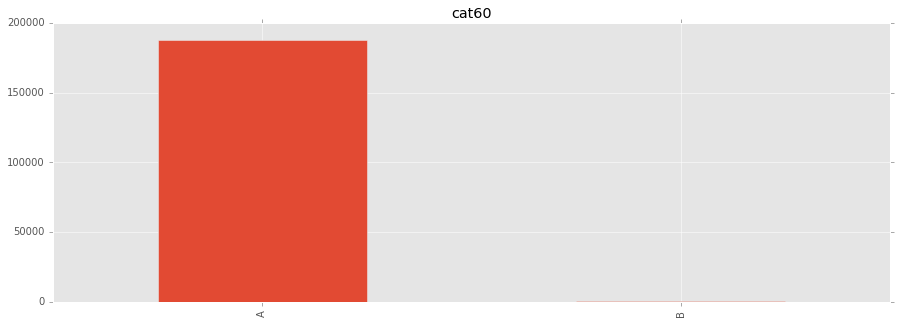

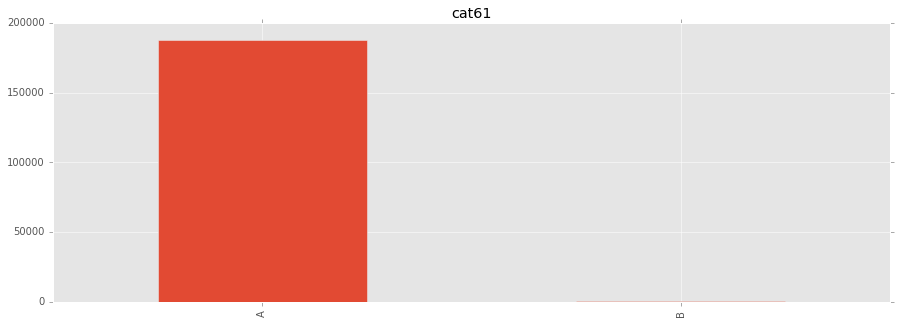

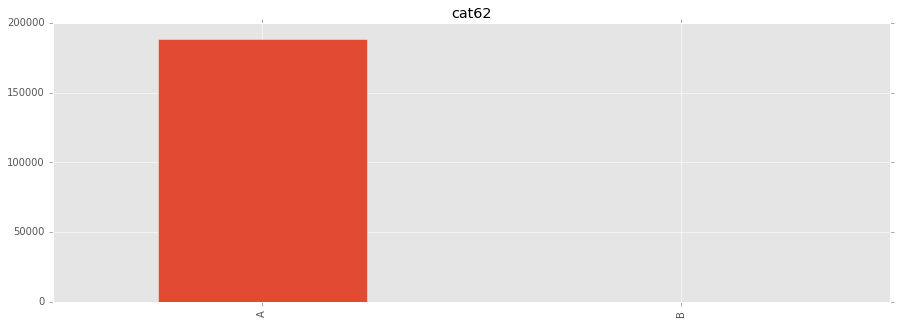

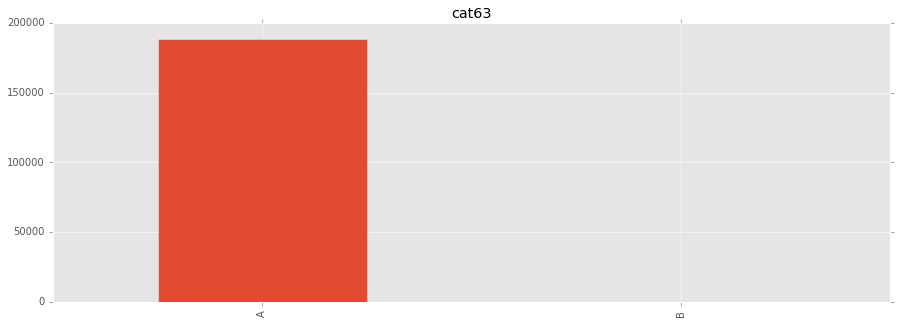

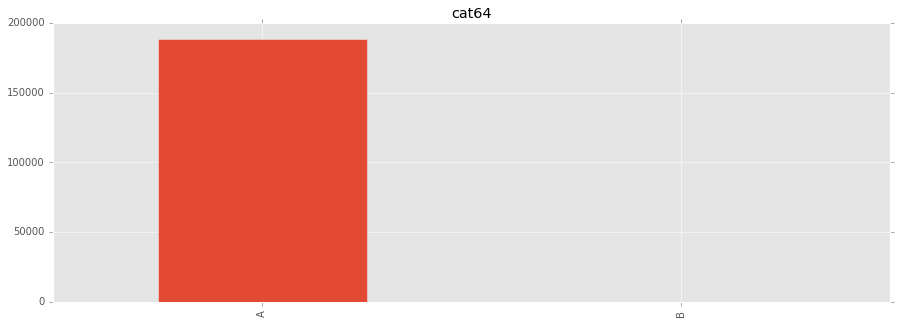

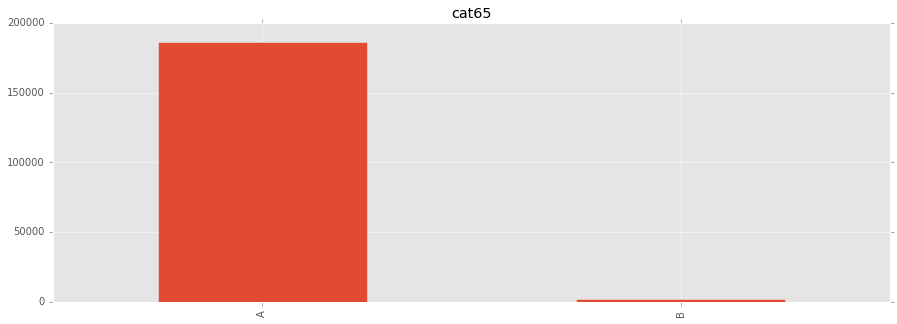

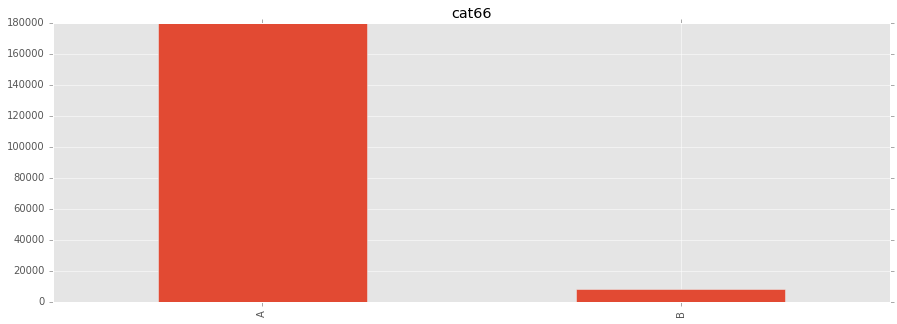

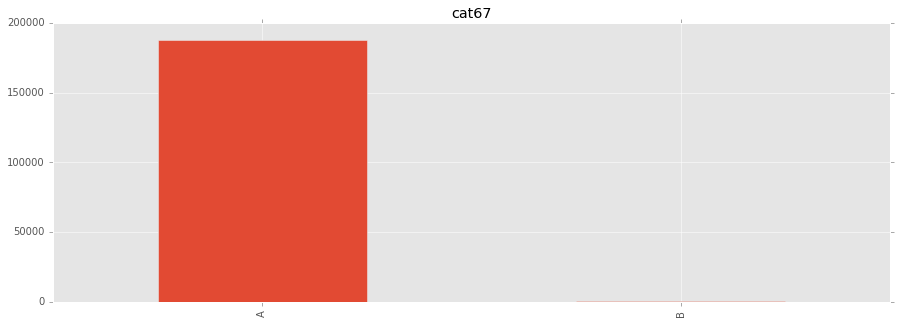

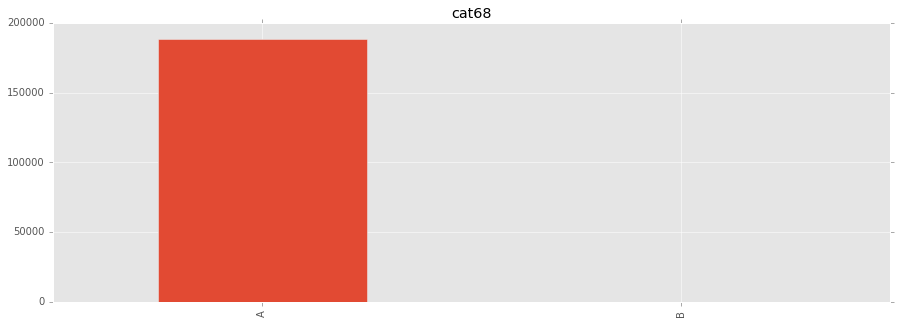

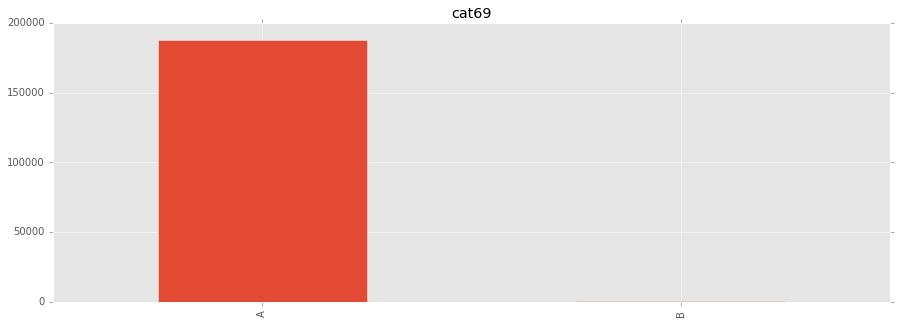

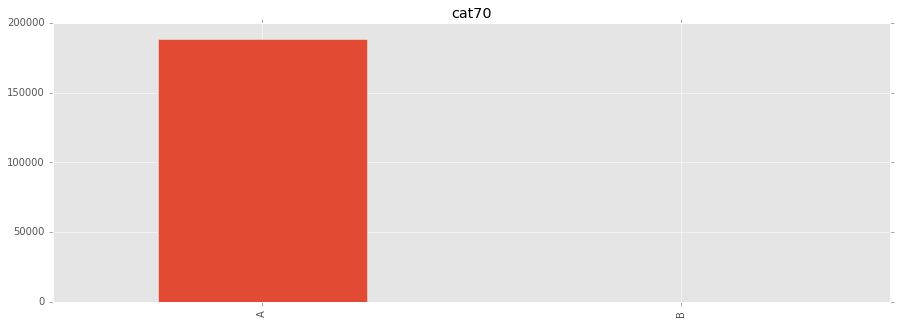

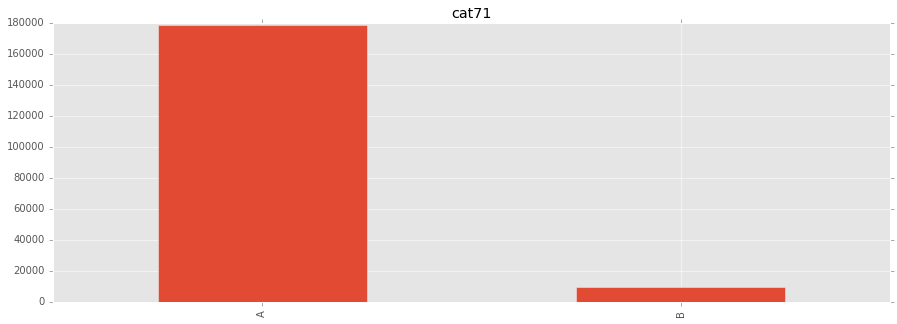

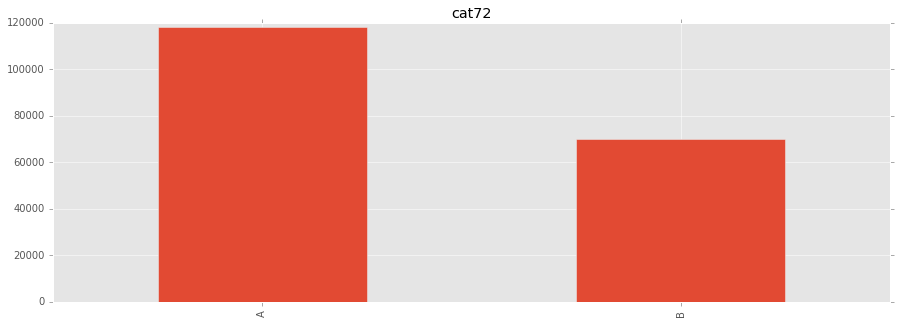

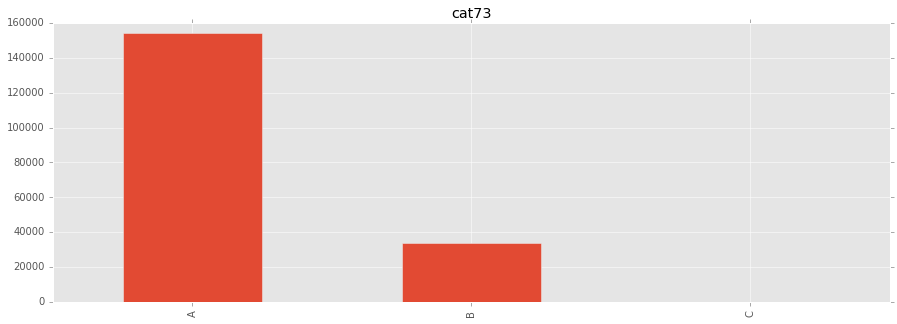

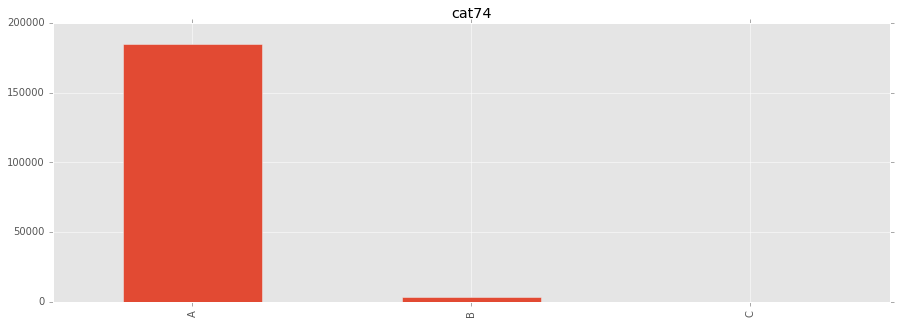

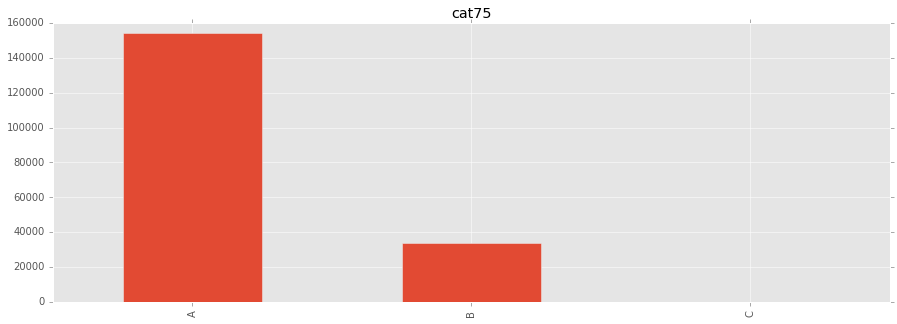

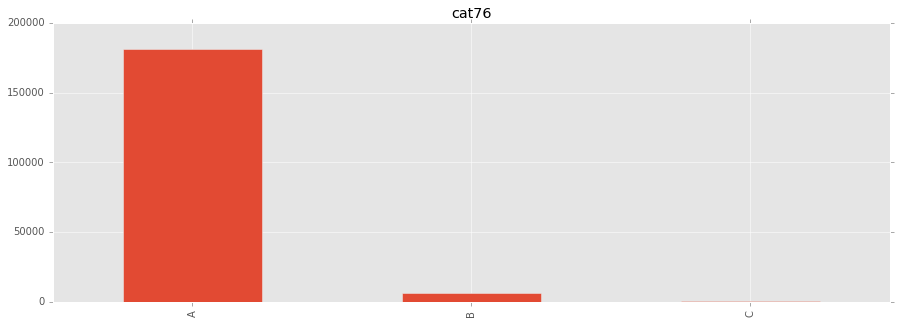

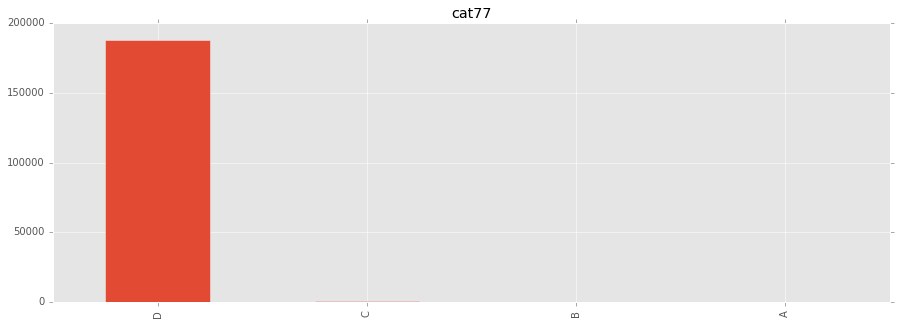

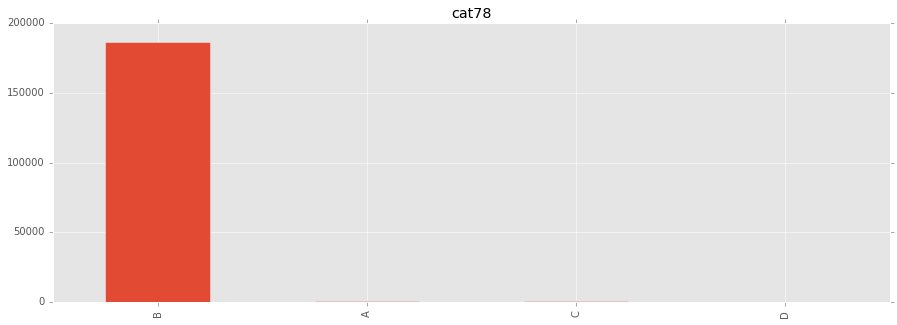

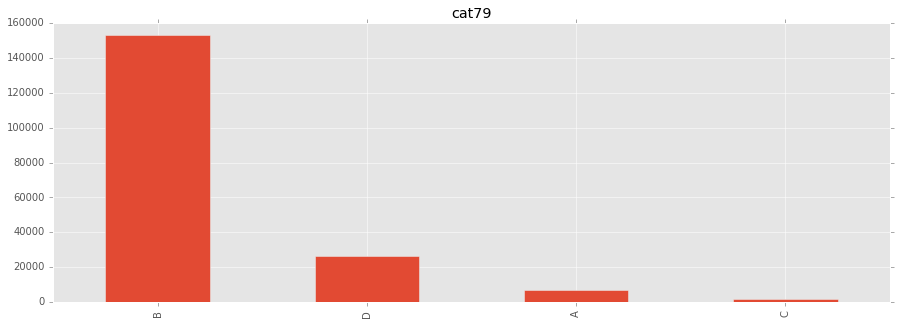

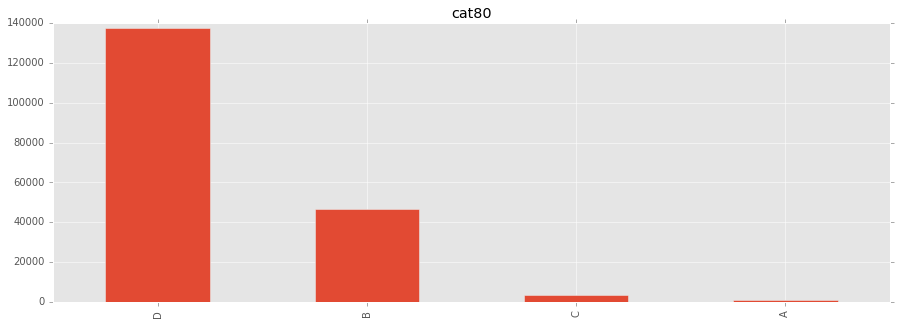

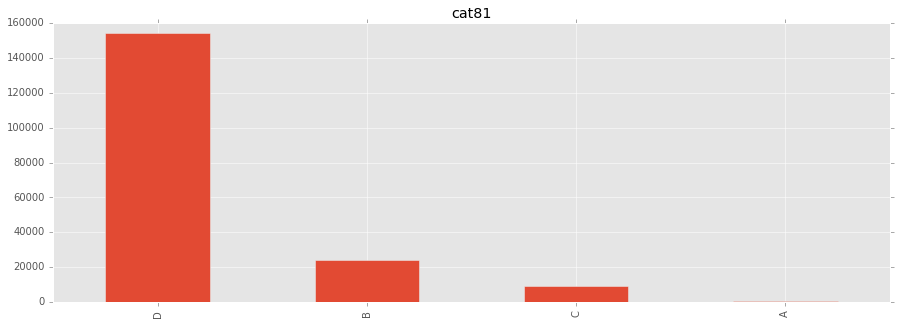

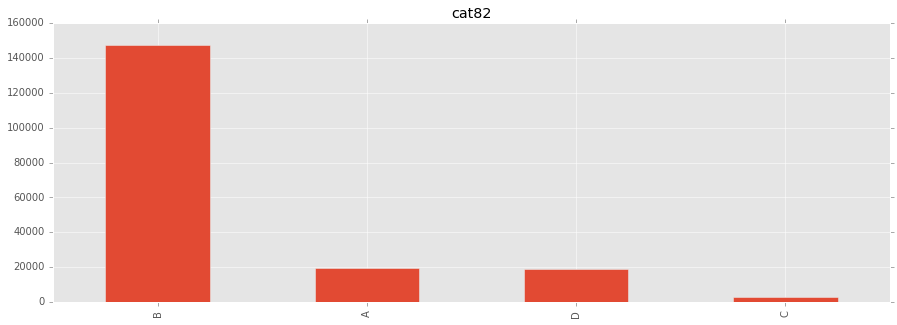

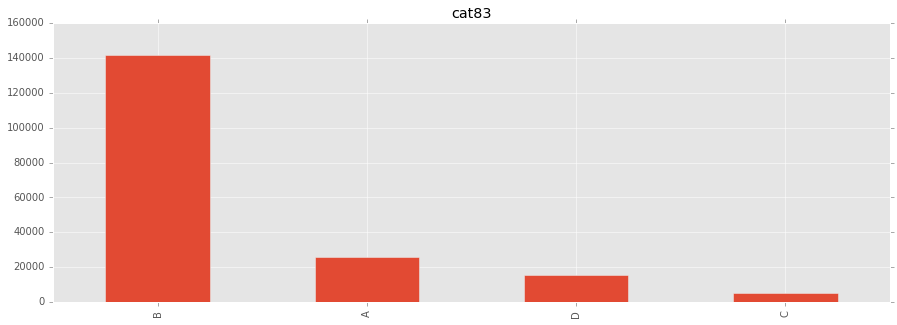

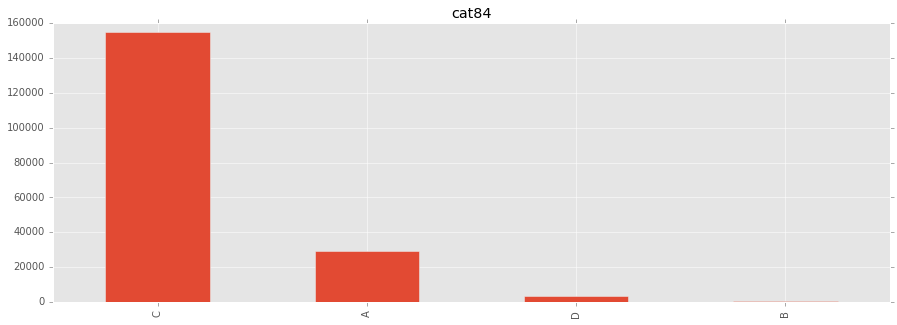

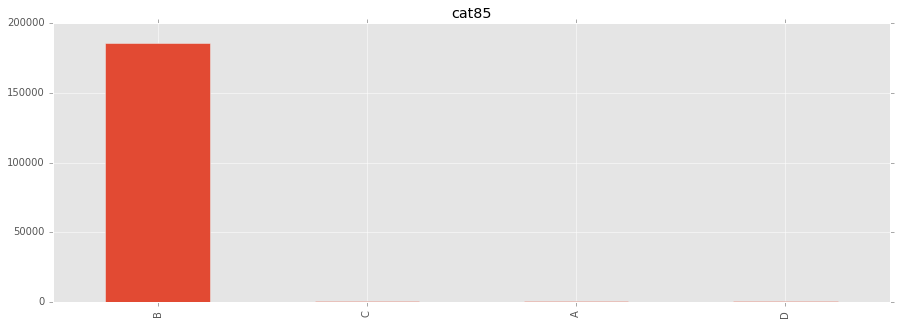

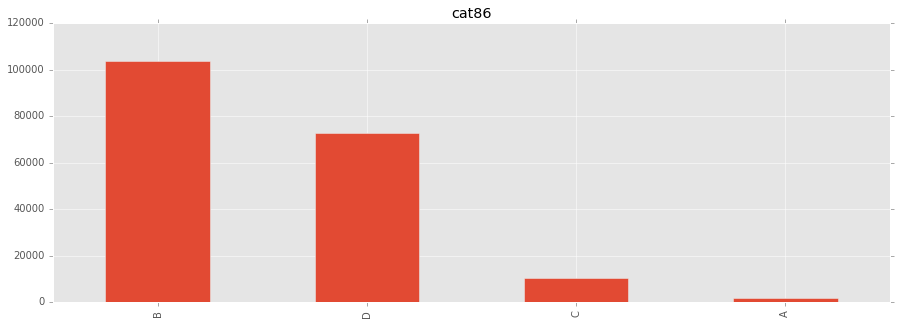

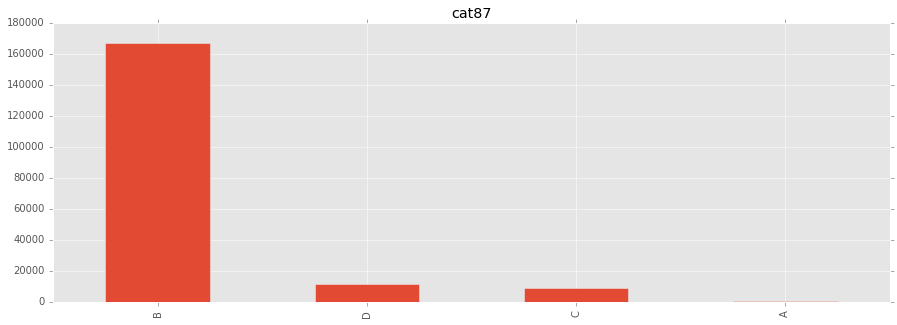

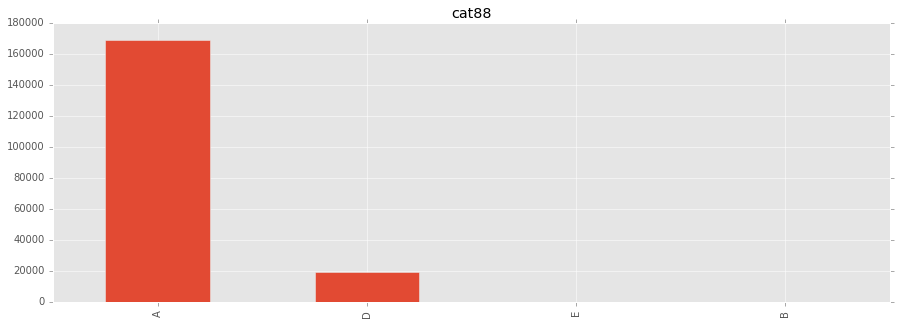

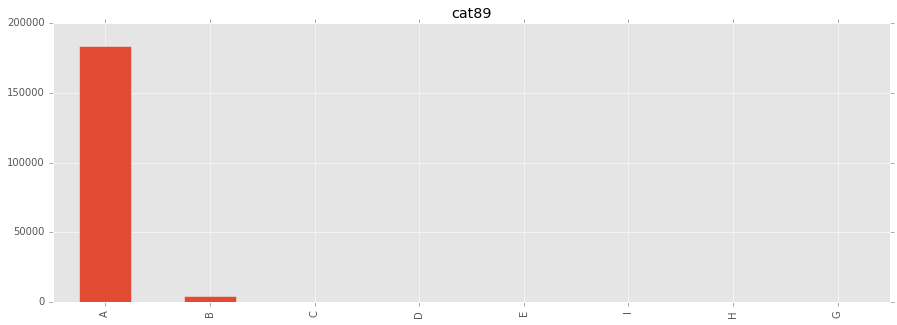

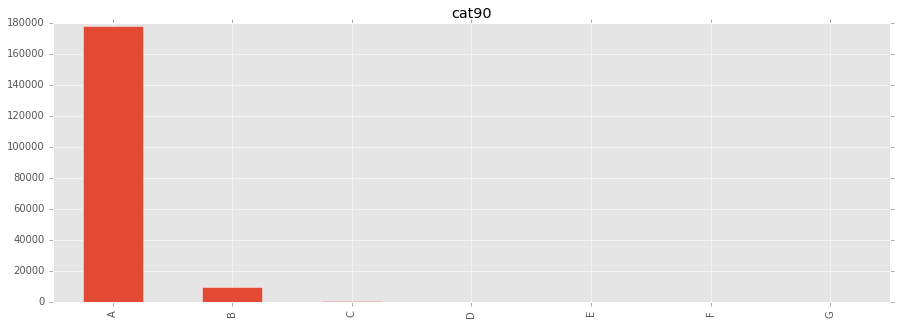

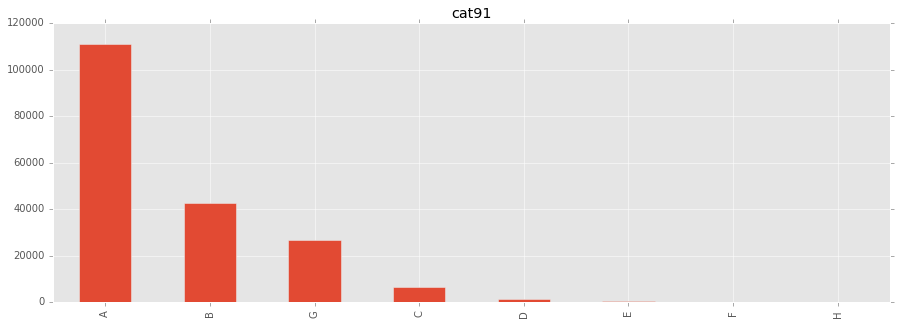

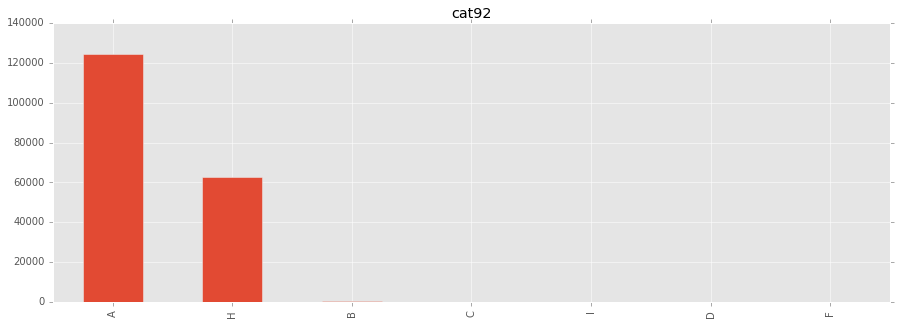

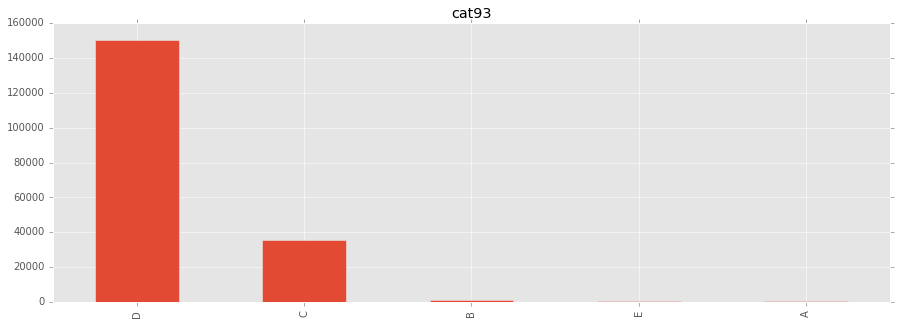

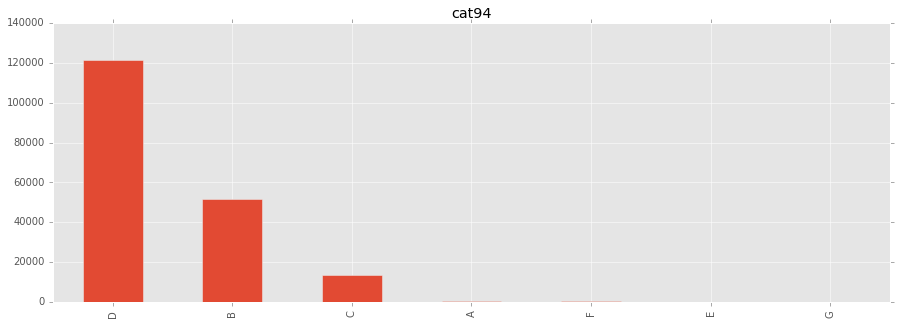

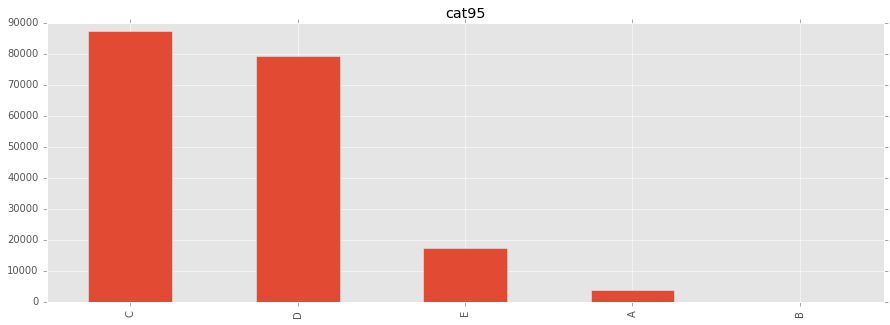

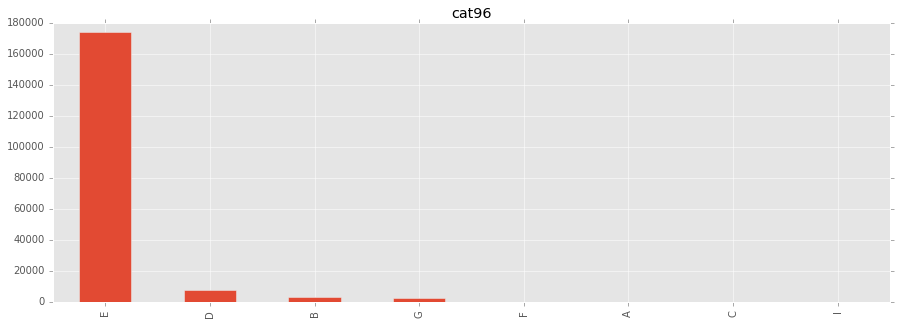

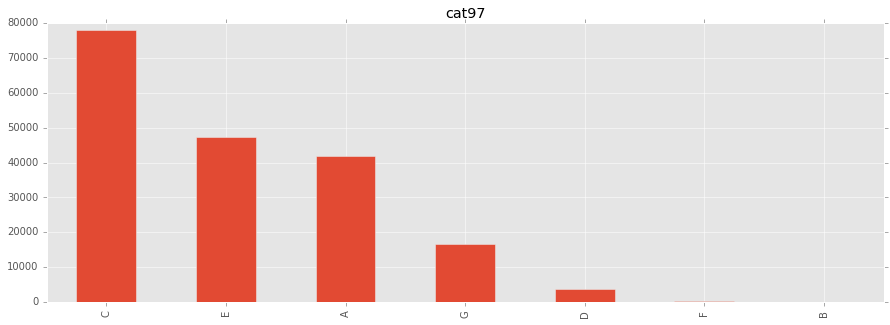

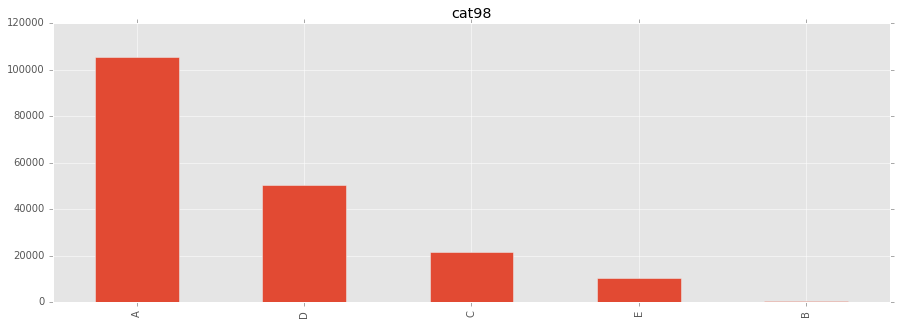

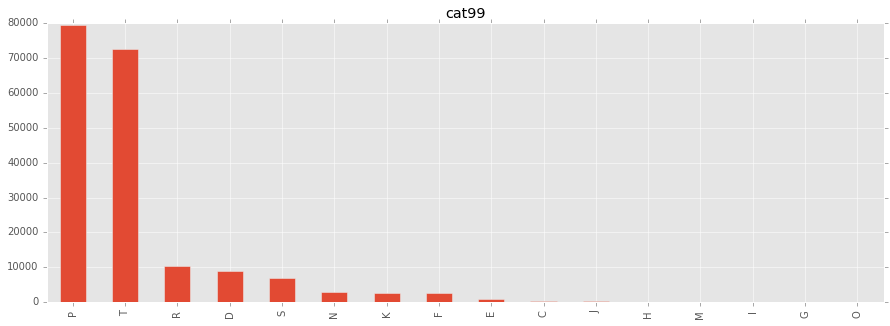

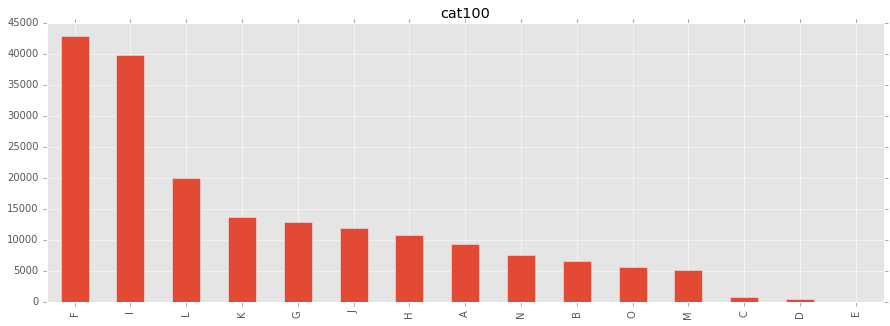

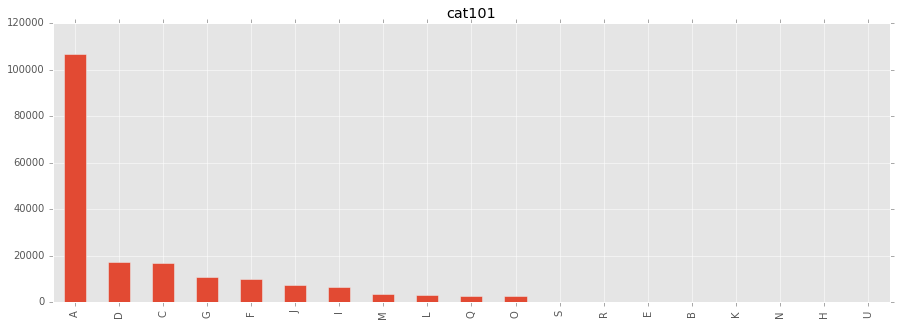

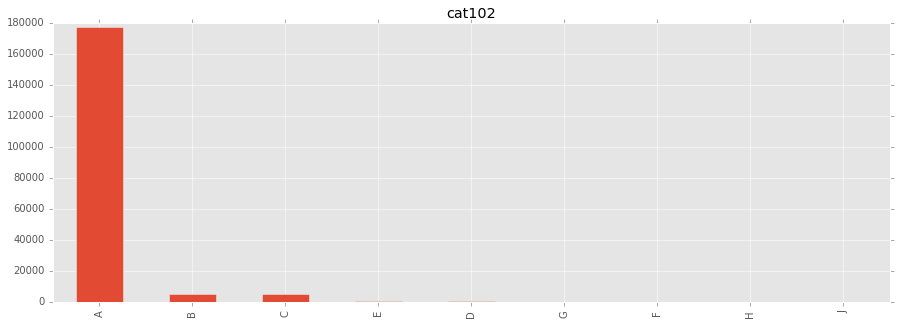

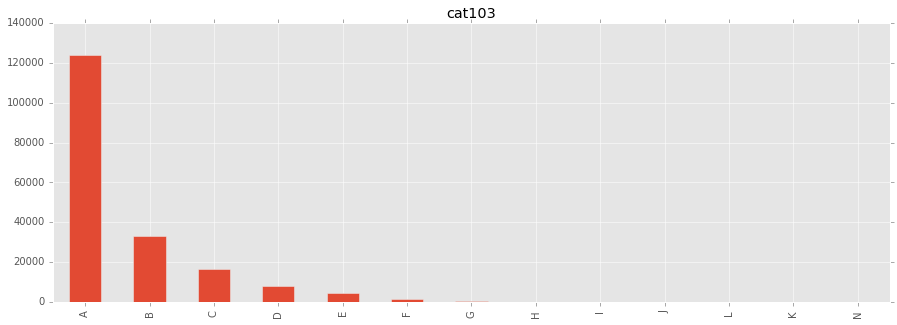

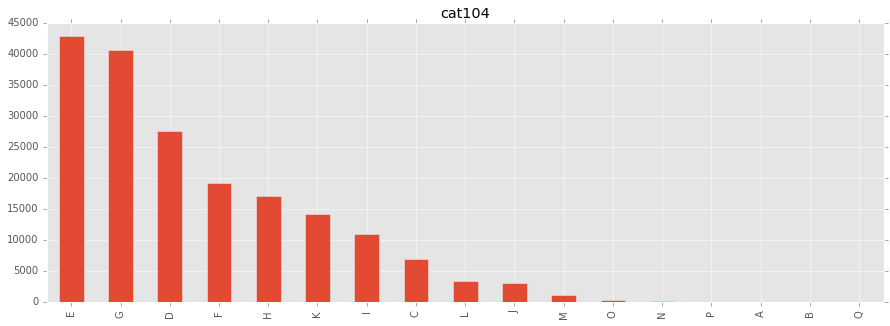

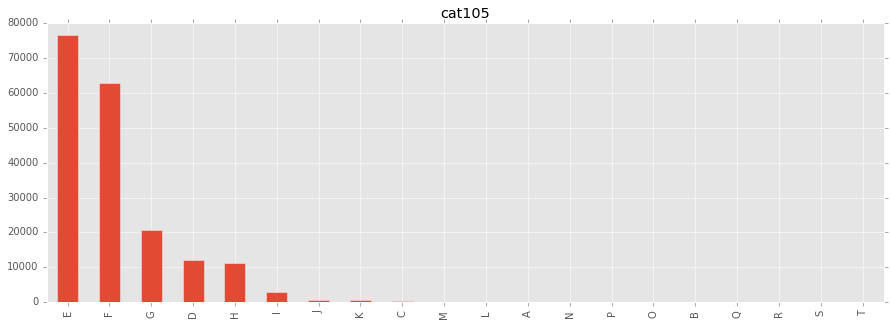

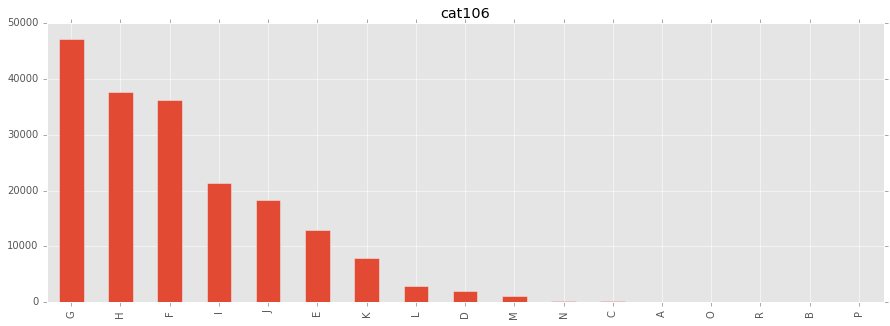

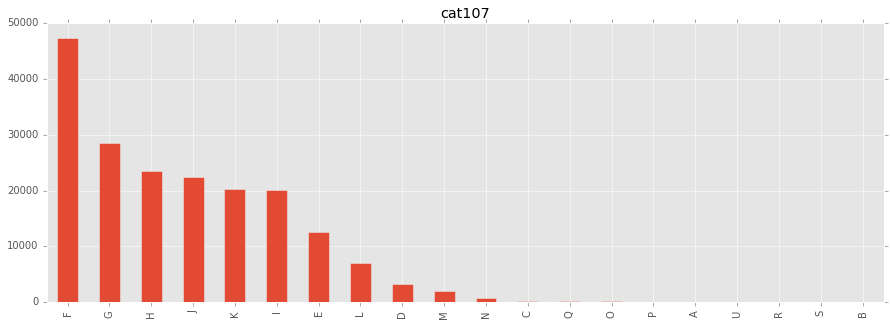

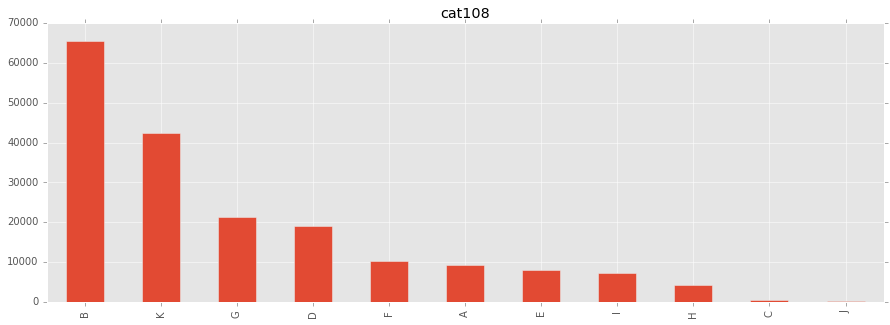

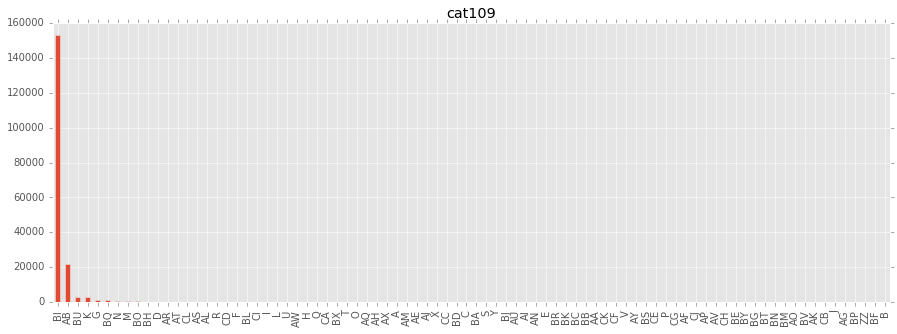

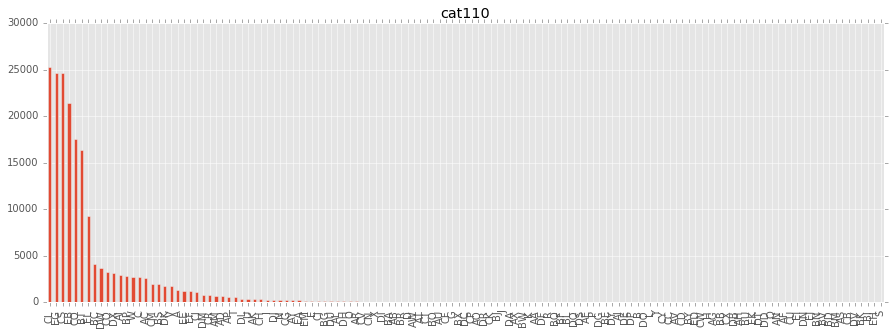

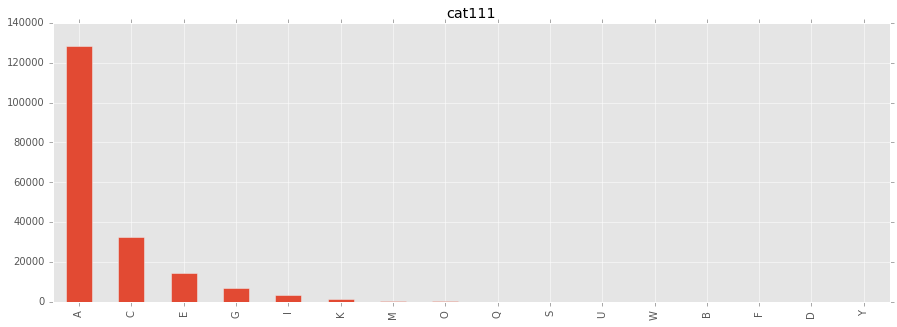

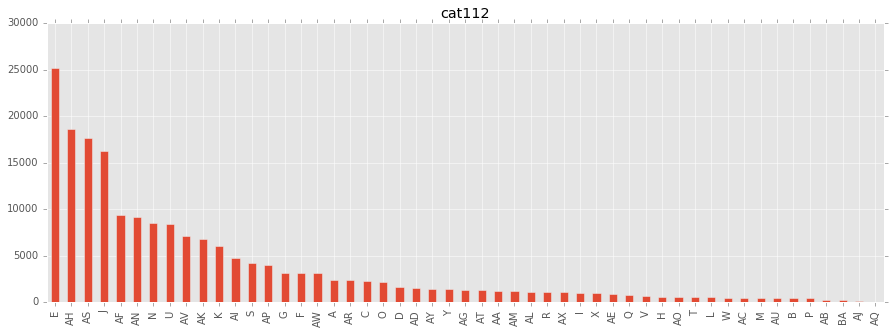

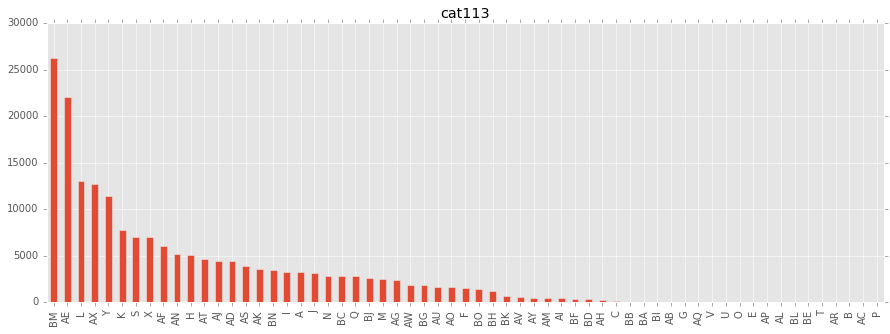

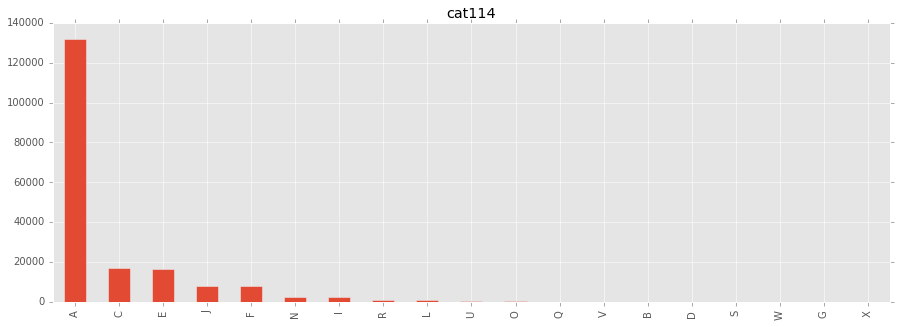

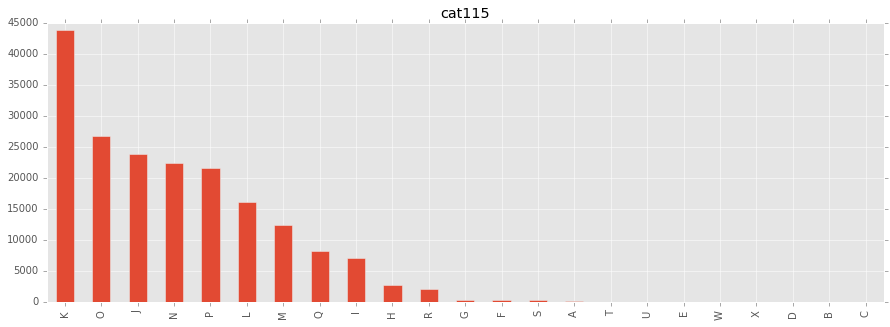

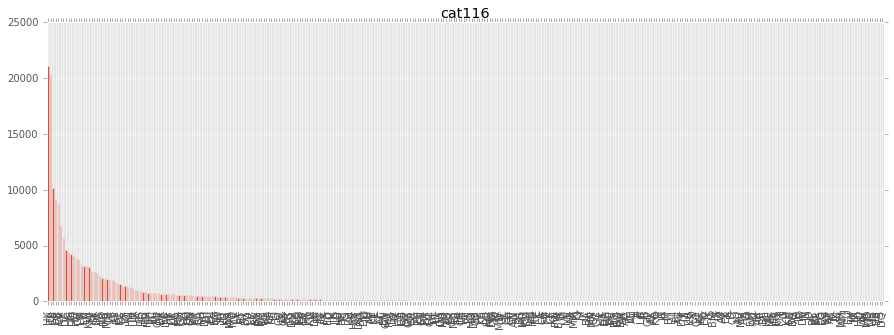

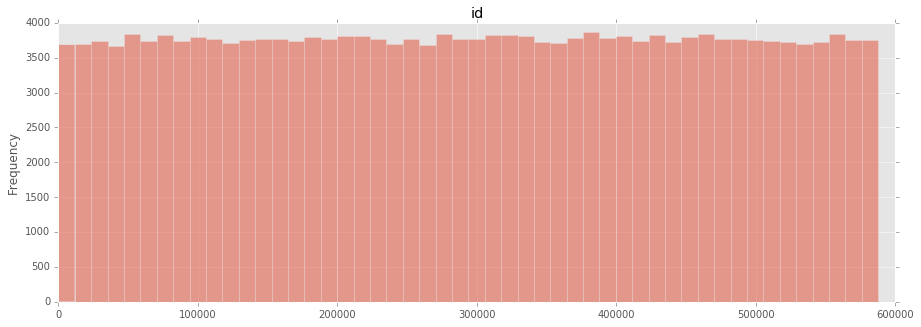

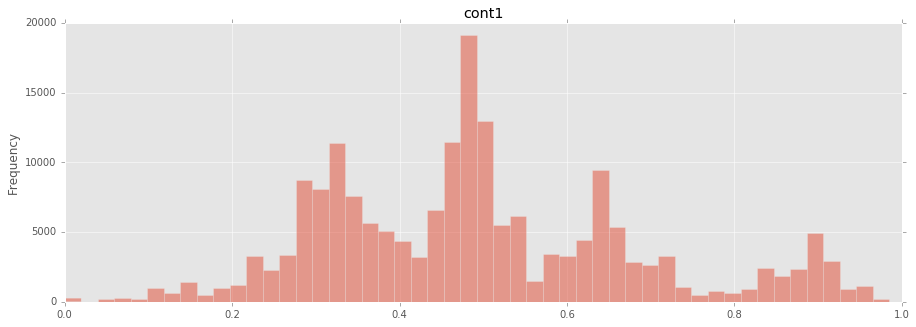

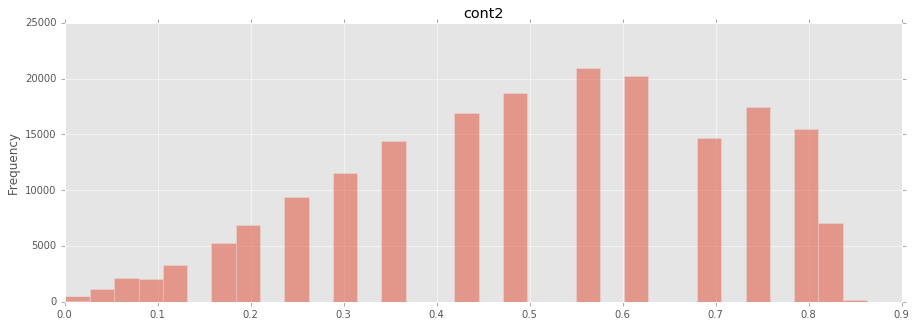

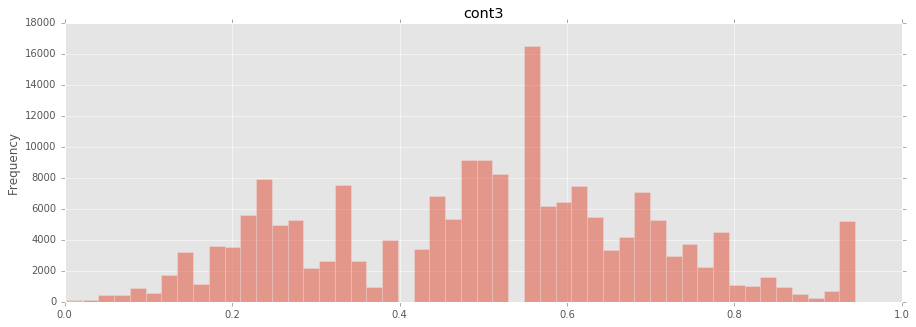

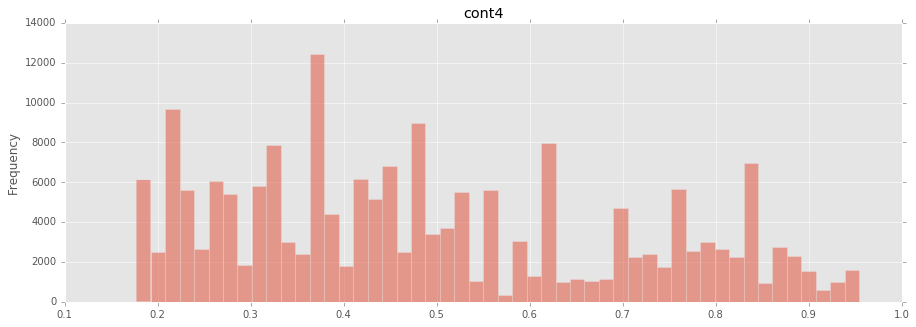

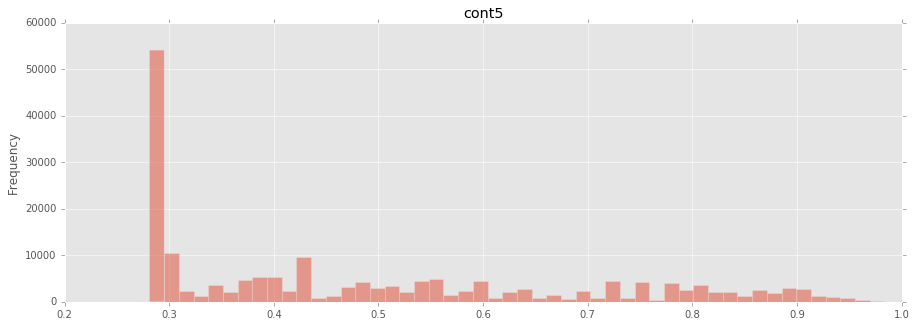

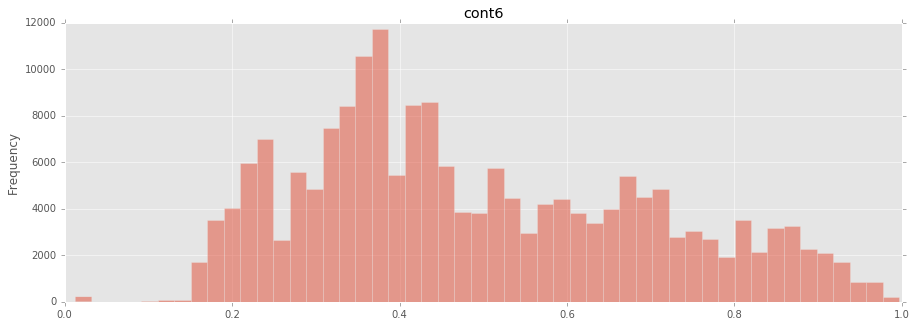

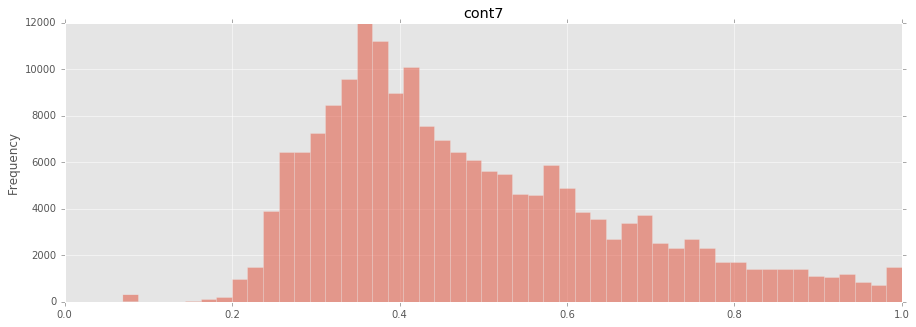

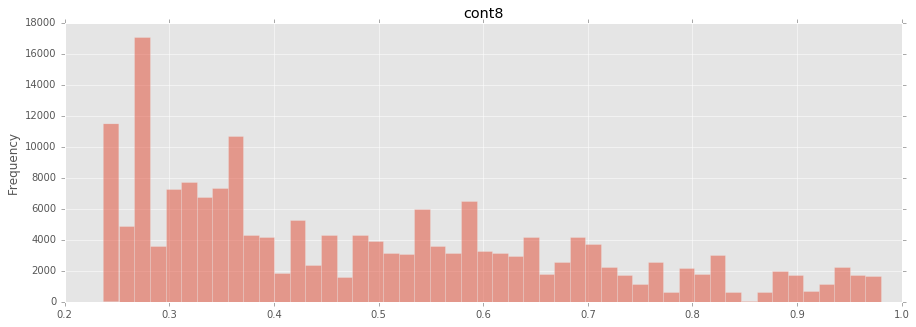

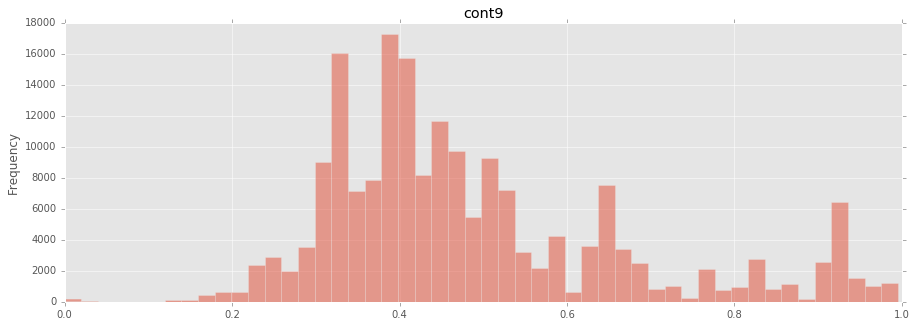

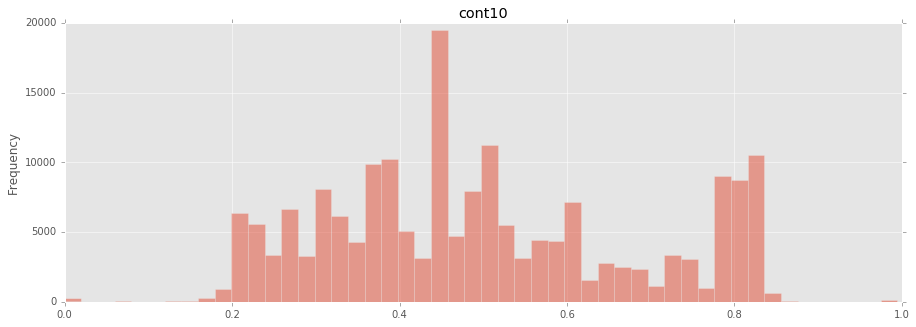

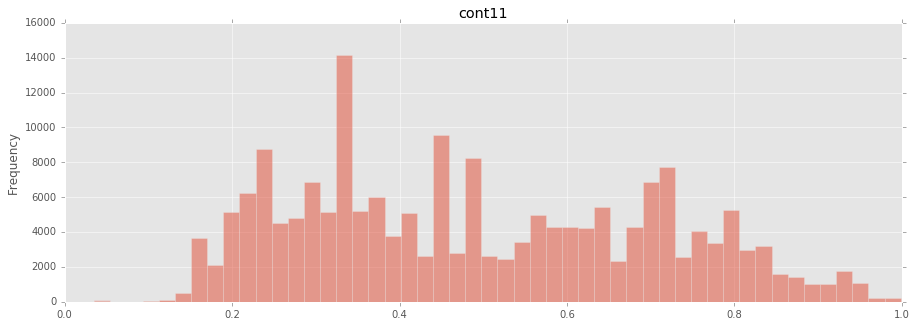

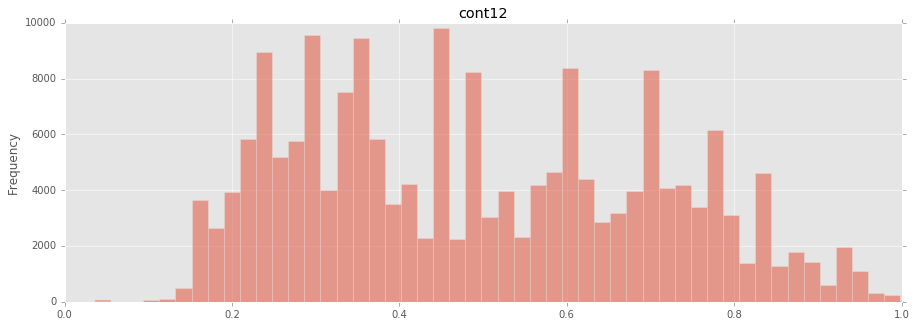

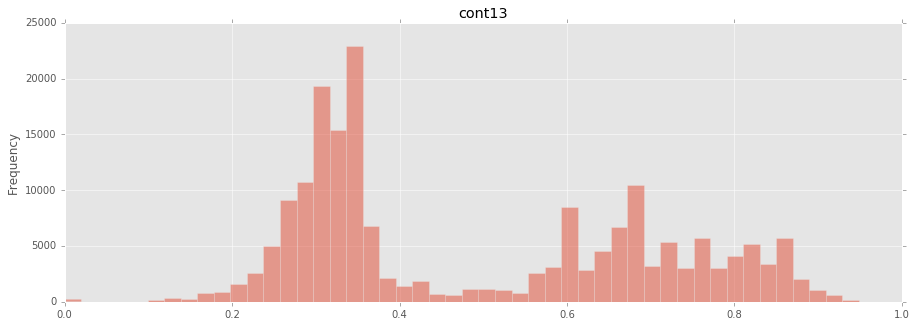

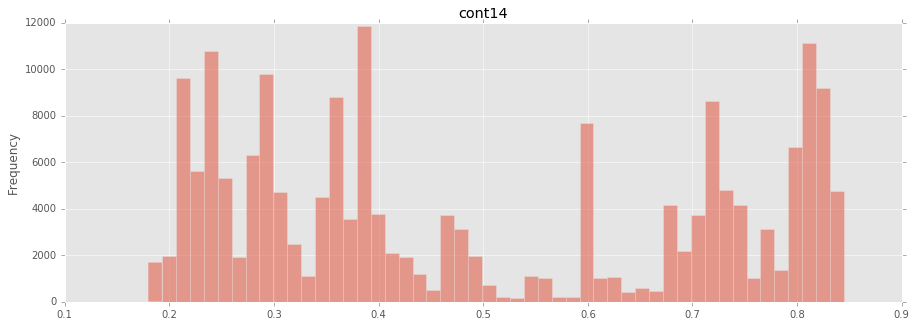

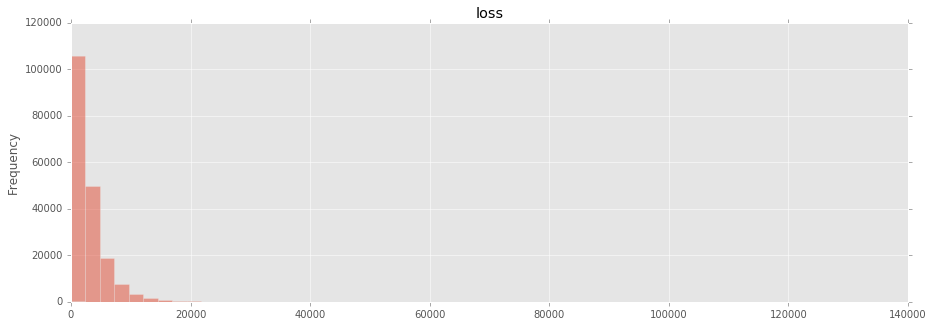

In [4]:
skutils.feature_hists(train_data, bins=50)

In [5]:
from sklearn import preprocessing

label_encoders = {}
category_labels = {}

def transform_x(data_df, phase="train"):
    """Transforms the input dataframe to a dataframe containing
    the input variables (= features)"""
    X = data_df.drop(['id'], axis=1)
    
    if 'loss' in X.columns:
        X = X.drop(['loss'], axis=1)
    
    # List of categorical features
    cat_features = X.select_dtypes(include=['object']).columns

    # List of numerical features
    num_features = X.select_dtypes(exclude=['object']).columns
    
    # Replace each categorical feature with encoded labels
    for cat in cat_features:
        if phase == "train":
            # Let's store the used labels
            category_labels[cat] = list(set(X[cat]))     
  
            # We need to fit the Label Encoder in the training phase
            label_encoders[cat] = preprocessing.LabelEncoder()
            label_encoders[cat].fit(X[cat])
        
        # We replace unseen labels by the first label
        mask = X[cat].apply(lambda x: x not in category_labels[cat])
        X.loc[mask, cat] = category_labels[cat][0]
        
        X[cat] = label_encoders[cat].transform(X[cat])
    
    return X

def transform_y(data_df):
    """Transforms the input dataframe to a dataframe containing
    the ground truth data"""
    y = data_df['loss']
    
    # You can do some crazy stuff here
    # y = np.log(y)
    
    return y

def inverse_transform_y(data):
    """Inverse transforms the y values to match the original
    Kaggle testing set"""
    y = data
    
    # You should invert all the crazy stuff
    # y = np.exp(y)
    
    return y

In [6]:
def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()

In [7]:
import xgboost as xgb

# Create our DMatrix to make XGBoost more efficient
xgdmat_train = xgb.DMatrix(transform_x(train_data).values, transform_y(train_data).values)

params = {'eta': 0.01, 'seed':0, 'subsample': 0.5, 'colsample_bytree': 0.5, 
             'objective': 'reg:linear', 'max_depth':6, 'min_child_weight':3} 

num_rounds = 100
mdl = xgb.train(params, xgdmat_train, num_boost_round=num_rounds)

In [10]:
import operator

features = [x for x in train_data.columns if x not in ['id','loss']]

ceate_feature_map(features)

importance = mdl.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

    feature    fscore
100   cont7  0.103074
99    cont2  0.081193
98   cont11  0.055515
97   cont12  0.045750
96   cat101  0.039421
95    cat81  0.036347
94    cont3  0.031646
93   cont14  0.027848
92    cat12  0.026221
91    cat94  0.023870
90   cat114  0.023508
89    cat57  0.022242
88    cat72  0.021881
87   cat111  0.021519
86     cat1  0.021338
85   cat103  0.019711
84   cat100  0.018445
83     cat7  0.018264
82    cat79  0.016998
81    cont6  0.016275
80   cont13  0.015190
79   cat116  0.012658
78    cat53  0.012297
77   cat105  0.011754
76     cat2  0.011392
75    cat89  0.011031
74    cont8  0.010127
73   cat106  0.009765
72    cat75  0.009584
71    cont1  0.008861
..      ...       ...
29    cat60  0.001447
26    cat91  0.001266
28    cat14  0.001266
27    cat84  0.001266
25    cat97  0.001085
23    cat98  0.000904
22    cat40  0.000904
21    cat16  0.000904
24    cat95  0.000904
20   cat102  0.000723
19    cat90  0.000723
18    cat93  0.000723
15    cat28  0.000542
14     cat

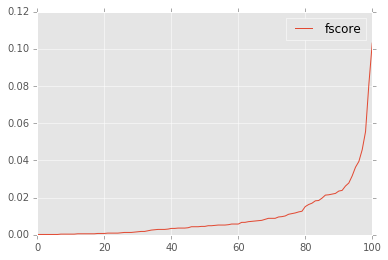

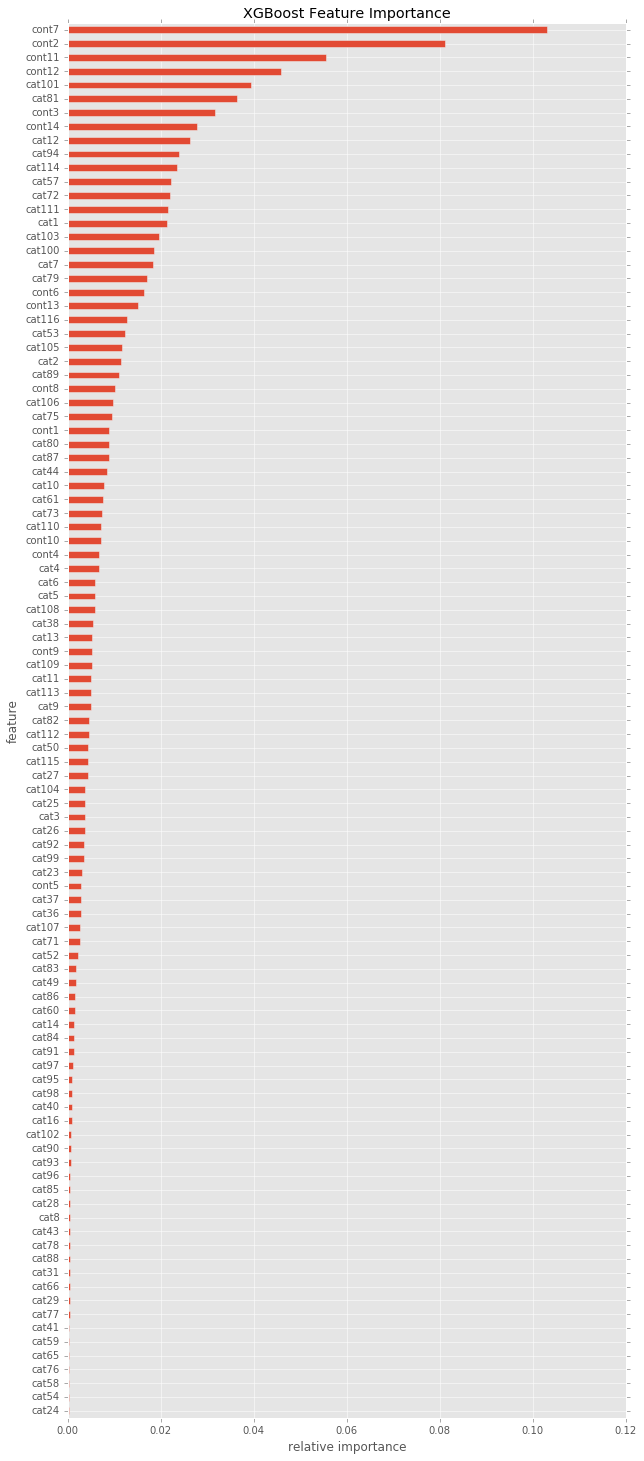

In [17]:
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 25))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

print(df.sort_values(by='fscore', ascending=False))